In [1]:
%matplotlib notebook

import time
import math
from importlib import reload

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 #dpi 100 before
import qcodes as qc
from qcodes import initialise_database
from qcodes.instrument import base, parameter
from qcodes import ParamSpec, new_data_set, new_experiment, Station
#from qcodes.dataset.plotting import plot_by_id, get_data_by_id
from plottr.qcodes_dataset import QcodesDatasetSubscriber as LivePlotSubscriber

In [3]:
# from qcodes.sweep import sweep, getter, setter, \
#     SweepMeasurement, nest, SweepWhile, time_trace, \
#     parallel_sweep

# Custom imports

In [2]:
from pytopo.awg_sequencing import broadbean as bbtools; reload(bbtools)
from pytopo.rf.alazar import acquisition_tools; reload(acquisition_tools)
from pytopo.rf.alazar import awg_sequences; reload(awg_sequences)
from pytopo.rf.alazar import acquisition_controllers; reload(acquisition_controllers)

<module 'pytopo.rf.alazar.acquisition_controllers' from 'd:\\code\\pytopo\\pytopo\\rf\\alazar\\acquisition_controllers.py'>

In [3]:
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_data_by_id

from pytopo.sweep.decorators import getter, setter
from pytopo.sweep import sweep, do_experiment, hardsweep, measure, nest, chain, szip


In [193]:
import Braiding2

# Measurement methods

## RampSequence

In [5]:
import broadbean as bb
from pytopo.awg_sequencing.broadbean import BroadBeanSequence
from broadbean.plotting import plotter

ramp = bb.PulseAtoms.ramp

class RampSequence(BroadBeanSequence):
    """
    required channels:
        'parameter' : analog output for the gate or bias voltage
        'ats_trigger' : marker output (for alazar)
    """
    
    name = "ramp_1d"
    voltage_scale_factor = 1.
    
    def sequence(self, npoints, time_per_point, 
                 val_start, val_stop, 
                 ramp_down_time=250e-6):
        #cycle_time = npoints * time_per_point + ramp_down_time
        self.parameter_vals = parameter_vals = np.linspace(val_start, val_stop, npoints) / self.voltage_scale_factor
        
        elements = []
        for i in range(npoints):
            bps = bbtools.BluePrints(chan_map=self.chan_map, length=time_per_point, sample_rate=self.SR)
            bps['parameter'].insertSegment(i, ramp, (parameter_vals[i], parameter_vals[i]), dur=time_per_point)
            bps['ats_trigger'] = [(100e-9 + i*time_per_point, 200e-9 + i*time_per_point)]
            elements.append(bbtools.blueprints2element(bps))
            
        bps = bbtools.BluePrints(chan_map=self.chan_map, length=ramp_down_time, sample_rate=self.SR)
        bps['parameter'].insertSegment(i, ramp, (parameter_vals[-1], parameter_vals[0]), dur=ramp_down_time)
        elements.append(bbtools.blueprints2element(bps))
        
        return bbtools.elements2sequence(elements, self.name)


# ramp1d_seq = RampSequence(station.awg, SR=1e7)
# ramp1d_seq.setup_awg(npoints=11, time_per_point=100e-6, 
#                          val_start=0, val_stop=0.1, 
#                          plot=True, start_awg=False)

## GateRampSequence 2-axes

In [6]:
import broadbean as bb
from pytopo.awg_sequencing.broadbean import BroadBeanSequence
from broadbean.plotting import plotter

ramp = bb.PulseAtoms.ramp

class GateRampSequence_2axes(BroadBeanSequence):
    """
    required channels:
        'gate' : analog output for the gate voltage
        'ats_trigger' : marker output (for alazar)
        'bias' : analog output for the bias voltage (symmetric)
    """
    
    name = "gateramp_2d"
    voltage_scale_factor_x = 1.
    voltage_scale_factor_y = 1.
    ramp_down_time = 250e-6
    initial_delay = 20e-6
    
    def sequence(self, npoints_x, npoints_y, time_per_point, 
                 biasval_start, biasval_stop, 
                 gateval_start, gateval_stop, 
                 ramp_down_time=ramp_down_time, initial_delay=initial_delay):
        cycle_time = npoints_y * time_per_point + ramp_down_time + initial_delay
        self.bias_vals = bias_vals = np.linspace(biasval_start, biasval_stop, npoints_x) / self.voltage_scale_factor_x
        self.gate_vals = gate_vals = np.linspace(gateval_start, gateval_stop, npoints_y) / self.voltage_scale_factor_y
        
        elements = []
        for j in range(npoints_x):
            bps = bbtools.BluePrints(chan_map=self.chan_map, length=cycle_time, sample_rate=self.SR)
            bps['gate'].insertSegment(1, ramp, (gate_vals[0], gate_vals[0]), dur=initial_delay)
            bps['bias'].insertSegment(1, ramp, (bias_vals[j], bias_vals[j]), dur=initial_delay)
            for i in range(npoints_y):
                
                bps['bias'].insertSegment(i+2, ramp, (bias_vals[j], bias_vals[j]), dur=time_per_point)
                bps['gate'].insertSegment(i+2, ramp, (gate_vals[i], gate_vals[i]), dur=time_per_point)
                #bps['ats_trigger'] = [(1e-6 + i*time_per_point, 6e-6 + i*time_per_point)]
                bps['ats_trigger'].append((1e-6+i*time_per_point+initial_delay, 500e-9))
            
            #elements.append(bbtools.blueprints2element(bps))
            
            #bps = bbtools.BluePrints(chan_map=self.chan_map, length=ramp_down_time, sample_rate=self.SR)
            bps['gate'].insertSegment(npoints_y+2, ramp, (gate_vals[-1], gate_vals[0]), dur=ramp_down_time)
            bps['bias'].insertSegment(npoints_y+2, ramp, (bias_vals[j], bias_vals[j]), dur=ramp_down_time)
            elements.append(bbtools.blueprints2element(bps))
        
        return bbtools.elements2sequence(elements, self.name)


# gateramp1d_seq = GateRampSequence(station.awg, SR=1e7)
# gateramp1d_seq.setup_awg(npoints=11, time_per_point=100e-6, 
#                          gateval_start=0, gateval_stop=0.1, 
#                          plot=True, start_awg=False)

# Init station and instruments

In [5]:
qc.config['core']['db_location'] = r".\U48.db"

initialise_database()

Upgrading database: : 0it [00:00, ?it/s]


In [483]:
%run -i D:/Code/Braiding2/Braiding2/init_station.py
# '-i' option allows to execute the code from the given python files
# as if it was typed in here, in the cell

Instrument alazar already exists.
Instrument LO already exists.
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110434, firmware:3.1.19.15-3.50.124.67) in 0.02s
Instrument RF already exists.
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110431, firmware:3.1.19.15-3.50.124.67) in 0.04s
Instrument hetsrc already exists.
Instrument ivvi already exists.
Initialized IVVI-rack in 0.02s
Instrument keithley_1 already exists.
Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:4107733, firmware:B01  /A02) in 0.05s
Instrument keithley_2 already exists.
Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:4117111, firmware:B01  /A02) in 0.06s
Instrument lockin_1 already exists.
Connected to: Stanford_Research_Systems SR830 (serial:s/n48001, firmware:ver1.07) in 0.04s
Instrument lockin_2 already exists.
Connected to: Stanford_Research_Systems SR830 (serial:s/n54434, firmware:ver1.07) in 0.04s
Instrument AMI430_X already exists.
Connected to: AMERICAN MAGNETICS INC. 430 (serial

d:\code\qcodes\qcodes\instrument_drivers\american_magnetics\AMI430.py:370: AMI430Warning: Increasing maximum ramp rate: we have a default current ramp rate limit of 0.06 A/s. We do not want to ramp faster than a set maximum so as to avoid quenching the magnet. A value of 0.06 A/s seems like a safe, conservative value for any magnet. Change this value at your own responsibility after consulting the specs of your particular magnet
  warn(warning_message, category=AMI430Warning)


Instrument AMI430_3D already exists.


## Add Alazar acquisition controllers

In [737]:
#raw_acq = instools.create_inst(acquisition_controllers.RawAcqCtl, 
#                               'raw_acq', 'alazar',
#                               allocate_samples=1e9, 
#                               force_new_instance=True)
#station = add2station(station, raw_acq)

# acquisition_controllers.PostDemodCtl._datadtype = np.int32
# post_demod_acq = instools.create_inst(acquisition_controllers.PostDemodCtl, 
#                                       'post_demod_acq', 'alazar',
#                                       allocate_samples=1e9, 
#                                       force_new_instance=True)
# station = add2station(station, post_demod_acq)

post_iq_acq = instools.create_inst(acquisition_controllers.PostIQCtl, 
                                   'post_iq_acq', 'alazar',
                                   #allocate_samples=1e9, 
                                   force_new_instance=True)
station = add2station(station, post_iq_acq)

Instrument post_iq_acq already exists.


## Setting up Alazar

In [738]:
acquisition_tools.simple_alazar_setup_ext_trigger(384, 2, 2) #samples per record, records per buffer, buffers per acq.

with station.alazar.syncing():
    #station.alazar.clock_source('EXTERNAL_CLOCK_10MHz_REF') #INTERNAL_CLOCK, FAST_EXTERNAL_CLOCK
    #station.alazar.clock_edge('CLOCK_EDGE_RISING')
    station.alazar.channel_range1(0.4)
    station.alazar.channel_range2(0.4)
    station.alazar.trigger_source1('CHANNEL_A') #EXTERNAL, CHANNEL_A, CHANNEL_B
    #station.alazar.decimation(1)
    #station.alazar.coupling1('DC')
    #station.alazar.coupling2('DC')
    #station.alazar.channel_range1(0.4)
    #station.alazar.channel_range2(0.4)
    #station.alazar.impedance1(50)
    #station.alazar.impedance2(50)
    #station.alazar.external_trigger_coupling('DC')
    #station.alazar.external_trigger_range('ETR_2V5') #ETR_TTL
    station.alazar.trigger_delay(0)
    #station.alazar.timeout_ticks(int(1e6))
    #station.alazar.buffer_timeout(int(1e4))
    station.alazar.trigger_level1(128 + 3) #127.5 is zero
    station.alazar.sample_rate(int(1e8))
    station.alazar.trigger_holdoff(True)

In [12]:
# NOTE: NEED TRIGGER SEQUENCE!!!

# station.hetsrc.IF(50e6)
# station.hetsrc.frequency(500e6)
# station.hetsrc.RF.on()
# station.hetsrc.LO.on()
# station.hetsrc.RF.power(-45)

# raw_acq.average_buffers(False)
# raw_acq.setup_acquisition(samples=None, records=1, buffers=2, acq_time=10e-6) #samples, records=1, buffers=2
# data = raw_acq.acquisition()

# print(data.shape)

## Init, measure, end for DC

In [723]:
Rs=(7.57+7.57+3+3)*1e3 #depends on the selected leads (18kOhm if both pads have 5kOhm)
Vrange=2e-3
Imeas=1e6
amplitude_1 = 10e-6  #Volt
lockin1_amplitude = amplitude_1*1e2/(Vrange*np.sqrt(2))
lockin2_amplitude = amplitude_1*1e2/(Vrange*np.sqrt(2))
phi_offset_deg = 90+9.4
phi_offset_rad = phi_offset_deg*np.pi/180.0

In [730]:
def init_DC():
    station.keithley_1.auto_range_enabled(True)
    station.keithley_1.nplc(4)
    
    station.keithley_2.auto_range_enabled(True)
    station.keithley_2.nplc(2)
    
    station.lockin_1.frequency(23)
    station.lockin_1.phase(0)
    #station.lockin_1.sensitivity(0.0005) # does not work, why?
    station.lockin_1.time_constant(0.3)
    station.lockin_1.amplitude(lockin1_amplitude)
    
    station.lockin_2.frequency(72)
    station.lockin_2.phase(0) #15
    station.lockin_2.sensitivity(0.0005)
    station.lockin_2.time_constant(0.3)
    station.lockin_2.amplitude(lockin2_amplitude)

def set_params(): 
    station.lockin_1.amplitude(lockin1_amplitude)
    station.lockin_2.amplitude(lockin2_amplitude)
    #station.lockin_1.sensitivity(0.0005) # does not work, why?
    #station.lockin_2.sensitivity(0.001)
    #station.lockin_1.time_constant(0.3)
    #station.lockin_2.time_constant(0.3)

#The decorated function below returns a callable and a parameter table. The callable calls the decorated function which \
#should return measurement values.
@getter(
    ('keithley_1', 'V'),
    #('keithley_2', 'V'),
    ('lockin_2_X', 'V'), 
    ('lockin_2_R', 'V'), 
    ('lockin_2_phase', 'deg'), 
    ('lockin_2_processed', 'S'),
    ('conductance', 'G_0')
)
def measure_DC():
    k_1 = station.keithley_1.amplitude()
    #k_2 = station.keithley_2.amplitude()
    lockin2_x = station.lockin_2.X()
    lockin2_r = station.lockin_2.R() 
    lockin2_p = station.lockin_2.P()     
    lockin2_processed = (lockin2_x/Imeas)/(amplitude_1/np.sqrt(2.0)-lockin2_x/Imeas*Rs)
    conductance = 12906.4037*lockin2_processed
    return  k_1, lockin2_x, lockin2_r , lockin2_p, lockin2_processed, conductance
    
def end_DC():
    #ivvi.set_dacs_zero()
    print('Measurement completed')
    pass

In [80]:
#ivvi.dac1.step = 10  # 10 mv is the maximum step size of the dac

gate_inter_delay = 100e-3  
gate_post_delay = 100e-3

bias_inter_delay = 100e-3
bias_post_delay = 100e-3

station.ivvi.dac1.inter_delay = 0.2*bias_inter_delay 
station.ivvi.dac1.post_delay = 0.2*bias_post_delay

station.ivvi.dac2.inter_delay = gate_inter_delay 
station.ivvi.dac2.post_delay = gate_post_delay

station.ivvi.dac3.inter_delay = 5*gate_inter_delay 
station.ivvi.dac3.post_delay = 5*gate_post_delay

station.ivvi.dac4.inter_delay = 0.01*gate_inter_delay  ## as a irrelevent dac (time)
station.ivvi.dac4.post_delay = 0.01*gate_post_delay

station.ivvi.dac5.inter_delay = gate_inter_delay 
station.ivvi.dac5.post_delay = gate_post_delay

station.ivvi.dac6.inter_delay = gate_inter_delay 
station.ivvi.dac6.post_delay = gate_post_delay

station.ivvi.dac7.inter_delay = gate_inter_delay 
station.ivvi.dac7.post_delay = gate_post_delay

station.ivvi.dac8.inter_delay = gate_inter_delay 
station.ivvi.dac8.post_delay = gate_post_delay

station.ivvi.dac9.inter_delay = gate_inter_delay 
station.ivvi.dac9.post_delay = gate_post_delay

station.ivvi.dac10.inter_delay = gate_inter_delay 
station.ivvi.dac10.post_delay = gate_post_delay

station.ivvi.dac11.inter_delay = gate_inter_delay 
station.ivvi.dac11.post_delay = gate_post_delay

station.ivvi.dac12.inter_delay = gate_inter_delay 
station.ivvi.dac12.post_delay = gate_post_delay

station.ivvi.dac13.inter_delay = gate_inter_delay 
station.ivvi.dac13.post_delay = gate_post_delay

station.ivvi.dac14.inter_delay = gate_inter_delay 
station.ivvi.dac14.post_delay = gate_post_delay

station.ivvi.dac15.inter_delay = 0.5*gate_inter_delay 
station.ivvi.dac15.post_delay = 0.5*gate_post_delay

station.ivvi.dac16.inter_delay = gate_inter_delay 
station.ivvi.dac16.post_delay = gate_post_delay

# rf frequency sweep

In [739]:
@getter(('mag', 'V'), ('phase', 'deg'))
def get_IQ():
    data = np.squeeze(ctl.acquisition()[0, 0, 0, 0])  # select [1st buffer, 1st record(!), 1st sample, CH_A only]
#     data = np.squeeze(ctl.acquisition()[0,0])  # this was giving 2 mag/phase values per single freq
    mag = np.abs(data)
    phase = np.angle(data, deg=True)
    return mag, phase

@getter(('mag1', 'V'), ('phase1', 'deg'), ('mag2', 'V'), ('phase2', 'deg')) # , ('phase_diff', 'deg'))
def get_IQ_inter():
    data = np.squeeze(ctl.acquisition())
    mag_1 = np.abs(data[0,0])
    mag_2 = np.abs(data[0,1])
    phase_2 = np.angle(data[0,1])
    data_corr = data * np.exp(-1j*phase_2)
    phase_1 = np.angle(data_corr[0,0])    

#     data_1 = np.squeeze(ctl.acquisition()[0, 0, 0, 0])  # select [1st buffer, 1st record(!), 1st sample, CH_A only]
#     mag_1 = np.abs(data_1)
#     phase_1 = np.angle(data_1, deg=True)
#     data_2 = np.squeeze(ctl.acquisition()[0, 0, 0, 1])  # select [1st buffer, 1st record(!), 1st sample, CH_A only]
#     mag_2 = np.abs(data_2)
#     phase_2 = np.angle(data_2, deg=True)
#     phase_diff = phase_1 - phase_2
    return mag_1, phase_1, mag_2, phase_2 # , phase_diff

In [747]:
new_experiment(name='rf_frequency_sweep', sample_name="")

station.hetsrc.IF(10.0e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(10)
station.hetsrc.LO.power(21)

ctl = station.post_iq_acq
#ctl.pre_acquire_func = station.awg.start
#ctl.post_acquire_func = station.awg.stop
ctl.average_buffers(False)
ctl.setup_acquisition(samples=None, records=1, buffers=2, acq_time=2e-3)
ctl.demod_frq(10e6)

#station.ivvi.dac13(-260)
so = sweep(station.hetsrc.frequency, np.arange(50e6, 600e6, 1e6))(
    measure(get_IQ_inter),
)
result = do_experiment("frequency_sweep/", so, live_plot=True)

Setup capture: 3.198976 MB total
 * Buffers: 2 (1.599488 MB/buffer) | (Allocated buffers: 2 = 3.198976 MB)
 * Records: 1 (1.599488 MB/record)
 * Samples: 199936 (= 1999.36 us)
 * Channels: 2
Starting experimental run with id: 418


In [19]:
station.hetsrc.RF.power(-50)

In [130]:
%prun   ctl.acquisition()

In [132]:
ctl._alazar.mode.get()

'NPT'

In [105]:
%load_ext line_profiler

ModuleNotFoundError: No module named 'line_profiler'

In [150]:
ctl.setup_acquisition(samples=None, records=1, buffers=2, acq_time=0.2e-3)
# station.hetsrc.frequency, np.linspace(160e6,160e6,100)
# station.ivvi.dac4, np.linspace(0,0,100)
so = sweep(station.hetsrc.frequency, np.linspace(160e6,160e6,100))(
    measure(get_IQ_inter),
)
def speed_test():
    for data in so:
        pass

%prun speed_test()

Setup capture: 0.319488 MB total
 * Buffers: 2 (0.159744 MB/buffer) | (Allocated buffers: 2 = 0.319488 MB)
 * Records: 1 (0.159744 MB/record)
 * Samples: 19968 (= 199.68 us)
 * Channels: 2
 

In [90]:
ctl.setup_acquisition(samples=None, records=1, buffers=2, acq_time=0.00256e-3)

so = sweep(station.hetsrc.frequency, np.linspace(160e6,160e6,11))(
    measure(get_IQ_inter),
)


ticc = time.time()
tarr = []
for data in so:
    pass #tarr.append(time.time())
    #print('time = ' + str((time.time() - ticc)) + ' sec')
    #print(*data.items())
    #print('*******time = ' + str((time.time() - ticc)) + ' sec')
tarr.append(time.time())
tarr = np.array(tarr)
print(tarr[-1]-ticc)

Setup capture: 0.004096 MB total
 * Buffers: 2 (0.002048 MB/buffer) | (Allocated buffers: 2 = 0.004096 MB)
 * Records: 1 (0.002048 MB/record)
 * Samples: 256 (= 2.56 us)
 * Channels: 2
0.47804760932922363


time = 0.7890791893005371 sec
('keithley_1', 0.0015343252) ('lockin_2_X', 0.000409545) ('lockin_2_R', 0.000411393) ('lockin_2_phase', -5.418) ('lockin_2_processed', 7.467515332258668e-05) ('conductance', 0.9637876751407001) ('ivvi_dac11', 0.0)
*******time = 0.7940795421600342 sec
time = 0.9530954360961914 sec
('keithley_1', 0.00151781598) ('lockin_2_X', 0.000409545) ('lockin_2_R', 0.000411334) ('lockin_2_phase', -5.424) ('lockin_2_processed', 7.467515332258668e-05) ('conductance', 0.9637876751407001) ('ivvi_dac11', 1.0101010101010102)
*******time = 0.9610962867736816 sec
time = 1.1181118488311768 sec
('keithley_1', 0.00150465003) ('lockin_2_X', 0.000409486) ('lockin_2_R', 0.000411334) ('lockin_2_phase', -5.424) ('lockin_2_processed', 7.464741902044846e-05) ('conductance', 0.9634297250409664) ('ivvi_dac11', 2.0202020202020203)
*******time = 1.125112771987915 sec
time = 1.3181321620941162 sec
('keithley_1', 0.00149489325) ('lockin_2_X', 0.000409486) ('lockin_2_R', 0.000411334) ('lockin_2

KeyboardInterrupt: 

## frequency sweep vs BG

In [103]:
new_experiment(name='frequency sweep vs BG', sample_name="Wires1711")
#to run this, make sure alazar trigger is CHANNEL_A, instead of EXTERNAL
station.hetsrc.IF(10.0e6)
#station.hetsrc.frequency(515.5e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(5) #-45 previously
station.hetsrc.LO.power(21) #15 previously

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=20.0e-3)
ctl.demod_frq(10.0e6)
ticc = time.time()

so = nest(
   sweep(station.ivvi.dac4, np.linspace(0, 50, 400)),
   sweep(station.hetsrc.frequency, np.arange(172.1e6, 172.4e6, 0.01e6))(
   measure(get_IQ_inter))
)

result = do_experiment("frequency_sweep vs BG/Wire 6", so, live_plot=True)
print('time = ' + str((time.time() - ticc)/60) + ' mins') 

Setup capture: 15.998975999999999 MB total
 * Buffers: 2 (7.9994879999999995 MB/buffer) | (Allocated buffers: 2 = 15.998975999999999 MB)
 * Records: 1 (7.9994879999999995 MB/record)
 * Samples: 999936 (= 9999.36 us)
 * Channels: 2
Starting experimental run with id: 859


KeyboardInterrupt: 

## frequency sweep vs bias

In [748]:
new_experiment(name='frequency sweep vs bias', sample_name="")
#to run this, make sure alazar trigger is CHANNEL_A, instead of EXTERNAL
station.hetsrc.IF(10e6)
#station.hetsrc.frequency(515.5e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(10) #-45 previously
station.hetsrc.LO.power(21) #15 previously

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=2e-3)
ctl.demod_frq(10e6)



so = nest(
   sweep(station.ivvi.dac1, np.linspace(0, 500, 50)),
   sweep(station.hetsrc.frequency, np.arange(50e6, 400e6, 0.5e6))(
   measure(get_IQ_inter))
)

result = do_experiment("frequency_sweep vs bias", so, live_plot=True)

Setup capture: 3.198976 MB total
 * Buffers: 2 (1.599488 MB/buffer) | (Allocated buffers: 2 = 3.198976 MB)
 * Records: 1 (1.599488 MB/record)
 * Samples: 199936 (= 1999.36 us)
 * Channels: 2
Starting experimental run with id: 419


KeyboardInterrupt: 

# rf acquisition at fix frequency vs dac 

## Measure RF only

In [749]:
station.ivvi.dac12()

92.62226291294746

In [753]:
new_experiment(name='rf meas. vs bias', sample_name="Wires1711")
station.hetsrc.IF(10.0e6)
station.hetsrc.frequency(95.5e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(10)
station.hetsrc.LO.power(21)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=10e-3)
ctl.demod_frq(10.0e6)

station.ivvi.dac1(250)



so = sweep(station.ivvi.dac1, np.linspace(500, -500, 501))(
   measure(measure_DC_and_IQ))

result = do_experiment("RF vs Vbias", so, live_plot=True)

Setup capture: 15.998975999999999 MB total
 * Buffers: 2 (7.9994879999999995 MB/buffer) | (Allocated buffers: 2 = 15.998975999999999 MB)
 * Records: 1 (7.9994879999999995 MB/record)
 * Samples: 999936 (= 9999.36 us)
 * Channels: 2
Starting experimental run with id: 422


## Measure RF only vs BG and Power 

In [395]:
station.hetsrc.RF.power(-50)

In [49]:
station.ivvi.dac1(43)
new_experiment(name='rf meas. vs ', sample_name="")
station.hetsrc.IF(10e6)
station.hetsrc.frequency(3.94e8)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
#station.hetsrc.RF.power(0)
station.hetsrc.LO.power(21)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=10e-3)
ctl.demod_frq(10e6)

##station.ivvi.dac1(43 ) #2mV/V
#station.ivvi.dac3(0)
#station.ivvi.dac13(-460)

so = nest(
   sweep(station.hetsrc.RF.power, np.linspace(-20, 20, 21)),
   sweep(station.ivvi.dac15, np.linspace(72, 82, 161))
   (measure(measure_DC_and_IQ))
    )


'''
so = nest(
   sweep(station.hetsrc.RF.power, np.linspace(0, -60, 20)),
   sweep(station.ivvi.dac11, np.linspace(-60, -45, 150))
   (measure(measure_DC_and_IQ))
    )
'''
result = do_experiment("power vs Coulomb peaks/D2", so, live_plot=True)

Setup capture: 15.998975999999999 MB total
 * Buffers: 2 (7.9994879999999995 MB/buffer) | (Allocated buffers: 2 = 15.998975999999999 MB)
 * Records: 1 (7.9994879999999995 MB/record)
 * Samples: 999936 (= 9999.36 us)
 * Channels: 2
Starting experimental run with id: 815


In [50]:
station.hetsrc.RF.power(0)

## Noise (measurement uncertainty) at fix frequency

In [75]:
station.ivvi.dac1(43)
#station.ivvi.dac3(0)

acq_time_list = np.array([10,5,2,1,0.5,0.2,0.1])*1e-3

for t in acq_time_list:
    new_experiment(name='rf meas. vs BG', sample_name="")
    station.hetsrc.IF(10e6)
    station.hetsrc.frequency(3.94e8 )
    station.hetsrc.RF.on()
    station.hetsrc.LO.on()
    station.hetsrc.RF.power(0)
    station.hetsrc.LO.power(21)

    ctl = station.post_iq_acq
    ctl.average_buffers(False)
    ctl.setup_acquisition(None, 1, 2, acq_time= t)
    ctl.demod_frq(10e6)

    so = sweep(station.ivvi.dac4, np.linspace(0, 1, 200))(
       measure(get_IQ_inter))

    result = do_experiment("D2 174 MHz / acq_time " + str(t), so, live_plot=True)

Setup capture: 15.998975999999999 MB total
 * Buffers: 2 (7.9994879999999995 MB/buffer) | (Allocated buffers: 2 = 15.998975999999999 MB)
 * Records: 1 (7.9994879999999995 MB/record)
 * Samples: 999936 (= 9999.36 us)
 * Channels: 2
Starting experimental run with id: 1024
Setup capture: 7.9994879999999995 MB total
 * Buffers: 2 (3.9997439999999997 MB/buffer) | (Allocated buffers: 2 = 7.9994879999999995 MB)
 * Records: 1 (3.9997439999999997 MB/record)
 * Samples: 499968 (= 4999.68 us)
 * Channels: 2
Starting experimental run with id: 1025
Setup capture: 3.198976 MB total
 * Buffers: 2 (1.599488 MB/buffer) | (Allocated buffers: 2 = 3.198976 MB)
 * Records: 1 (1.599488 MB/record)
 * Samples: 199936 (= 1999.36 us)
 * Channels: 2
Starting experimental run with id: 1026
Setup capture: 1.599488 MB total
 * Buffers: 2 (0.799744 MB/buffer) | (Allocated buffers: 2 = 1.599488 MB)
 * Records: 1 (0.799744 MB/record)
 * Samples: 99968 (= 999.68 us)
 * Channels: 2
Starting experimental run with id: 102

## Measure RF and DC

In [750]:
@getter(
    ('mag1', 'V'), 
    ('phase1', 'deg'), 
    ('mag2', 'V'), 
    ('phase2', 'deg'),
    ('keithley_1', 'V'),
    ('lockin_2_X', 'V'), 
    ('lockin_2_phase', 'deg'), 
    ('lockin_2_processed', 'S'),
    ('conductance', 'G_0')           
)
def measure_DC_and_IQ():
    data = np.squeeze(ctl.acquisition())
    mag_1 = np.abs(data[0,0])
    mag_2 = np.abs(data[0,1])
    phase_2 = np.angle(data[0,1])
    data_corr = data * np.exp(-1j*phase_2)
    phase_1 = np.angle(data_corr[0,0])    

    
    k_1 = station.keithley_1.amplitude()
    #k_2 = keithley_2.amplitude()
    lockin2_x = station.lockin_2.X()
    lockin2_p = station.lockin_2.P()     
    lockin2_processed = (lockin2_x/Imeas)/(amplitude_1/np.sqrt(2.0)-lockin2_x/Imeas*Rs)
    conductance = 12906.4037*lockin2_processed
    return  mag_1, phase_1, mag_2, phase_2, k_1, lockin2_x, lockin2_p, lockin2_processed, conductance


In [18]:
@getter(
    ('mag1', 'V'), 
    ('phase1', 'deg'), 
    ('mag2', 'V'), 
    ('phase2', 'deg'),
    ('keithley_1', 'V')        
)
def measure_kei_and_IQ():
    data = np.squeeze(ctl.acquisition())
    mag_1 = np.abs(data[0,0])
    mag_2 = np.abs(data[0,1])
    phase_2 = np.angle(data[0,1])
    data_corr = data * np.exp(-1j*phase_2)
    phase_1 = np.angle(data_corr[0,0])    

    
    k_1 = station.keithley_1.amplitude()
    
    return  mag_1, phase_1, mag_2, phase_2, k_1


In [153]:
station.ivvi.dac3(200)
#station.hetsrc.RF.power(5)

In [152]:
new_experiment(name='TG', sample_name="")

station.hetsrc.IF(10e6)
station.hetsrc.frequency(1.7233e8)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(5) #-45 previously
station.hetsrc.LO.power(21) #15 previously

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=25.0e-3)
ctl.demod_frq(10e6)


#so = nest(
#   sweep(station.ivvi.dac1, np.linspace(-400, 400, 80))(
#   measure(measure_DC_and_IQ))    
#)

station.ivvi.dac1(500)
#station.ivvi.dac3(300)
#station.ivvi.dac11(100)
#station.ivvi.dac13(-270)

so = sweep(station.ivvi.dac3, np.linspace(-600, 1000, 1601))(
   measure(measure_DC_and_IQ))

result = do_experiment("TG1_sweep RF_and_DC/D2", so, [init_DC, set_params], end_DC, live_plot=True)
#station.ivvi.dac3(0)

Setup capture: 39.999488 MB total
 * Buffers: 2 (19.999744 MB/buffer) | (Allocated buffers: 2 = 39.999488 MB)
 * Records: 1 (19.999744 MB/record)
 * Samples: 2499968 (= 24999.68 us)
 * Channels: 2
Currently allocated data not sufficient: Need {self.data_size}, have {self.data.size}
Allocating 9999872 elements (39.999488 MB, dtype: <class 'numpy.int32'>)
Starting experimental run with id: 1084
Measurement completed


In [134]:
station.ivvi.dac13(0)

In [28]:
#station.ivvi.dac3(50)
station.ivvi.dac6(100)
station.ivvi.dac7(100)
station.ivvi.dac11(100)
station.ivvi.dac13(100)
station.ivvi.dac15(100)
#station.ivvi.dac15(70)

In [106]:
new_experiment(name='PG', sample_name="")

station.hetsrc.IF(10e6)
#station.hetsrc.frequency(3.94e8)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(5) 
station.hetsrc.LO.power(21) #15 previously

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=20.0e-3)
ctl.demod_frq(10e6)

ticc = time.time() 

#station.ivvi.dac1(500+43)

so = nest(
   sweep(station.ivvi.dac15, np.linspace(-280, -200, 81)),
   sweep(station.hetsrc.frequency, np.arange(172.15e6, 172.4e6, 0.01e6))
   (measure(get_IQ_inter))
)
#so = nest(
#   sweep(station.ivvi.dac15, np.linspace(-280, -150, 401)),
#   sweep(station.ivvi.dac1, np.linspace(-1500+43, 1500+43, 301))
#   (measure(measure_DC_and_IQ))
#)

#so = sweep(station.ivvi.dac15, np.linspace(0, 200, 200))(
#   measure(get_IQ_inter))

result = do_experiment("Diamond scan/D2", so, [init_DC, set_params], end_DC, live_plot=True)
print('time = ' + str((time.time() - ticc)/60) + ' mins') 

Setup capture: 32.0 MB total
 * Buffers: 2 (16.0 MB/buffer) | (Allocated buffers: 2 = 32.0 MB)
 * Records: 1 (16.0 MB/record)
 * Samples: 2000000 (= 20000.0 us)
 * Channels: 2
Starting experimental run with id: 1055
Measurement completed


KeyboardInterrupt: 

In [99]:
station.ivvi.dac1(43)

In [ ]:
station.ivvi.dac15(0)
station.ivvi.dac1(43+100)

# DC measurements

## Vbias sweep

In [734]:
new_experiment(name  = 'Vbias_sweep', sample_name="U48_1.1")


V_start = -400 + 44 #2mV/V
V_end = 400 + 44
n_steps = 401


result = do_experiment("bias sweep/U48_1.1",
        sweep(station.ivvi.dac1, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 408
Measurement completed


In [707]:
station.AMI430_3D.x.set_to(0.09)

In [708]:
station.AMI430_3D.x.get()

0.09

In [321]:
new_experiment(name  = 'Vbias_sweep', sample_name="U48")

station.ivvi.dac3(0)
station.ivvi.dac4(200)
station.ivvi.dac5(-530)
station.ivvi.dac1(-300+66) #-400+105
V_start = -300 + 66 #2mV/V
V_end = 300 + 66
n_steps = 301



result = do_experiment("bias sweep/U48",
        sweep(station.ivvi.dac1, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 126
Measurement completed


In [281]:
station.AMI430_3D.x.get()

0.3

In [72]:
station.ivvi.dac1(50)

## BG sweep

In [27]:
new_experiment(name='wire', sample_name="wire")

station.ivvi.dac1(500) #2mV/V


V_start = 0 #5V/V
V_end = 500
n_steps = 200

result = do_experiment("BG sweep/D2",
        sweep(station.ivvi.dac3, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC,
            set_params,
        ],
        end_DC,
        live_plot=True
    )


Starting experimental run with id: 797
Measurement completed


KeyboardInterrupt: 

In [22]:
station.ivvi.dac6(0)
station.ivvi.dac7(0)
station.ivvi.dac11(0)
station.ivvi.dac13(0)
station.ivvi.dac15(0)

In [463]:
new_experiment(name='CG2_sweep', sample_name="U32")


station.ivvi.dac1(43) #2mV/V
station.ivvi.dac4(600) #5V/V
station.ivvi.dac5(1000)
station.ivvi.dac6(1000)
station.ivvi.dac11(1000)

V_start = 400 #5V/V
V_end = 600
n_steps = 200

result = do_experiment("CG2",
        sweep(station.ivvi.dac7, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 477
Measurement completed


In [465]:

new_experiment(name='CG2_sweep', sample_name="U32")


station.ivvi.dac1(43) #2mV/V
#station.ivvi.dac4(600) #5V/V
#station.ivvi.dac5(1000)
station.ivvi.dac6(1000)
station.ivvi.dac11(1000)


result = do_experiment("TG1vsCG1",
        nest(
    sweep(station.ivvi.dac4, np.linspace(150, 600, 40)), 
    sweep(station.ivvi.dac5, np.linspace(200, 800, 40)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 479
Measurement completed


## Plunger gate sweep 

In [735]:
new_experiment(name='PG_sweep', sample_name="U48_1.1")

station.ivvi.dac1(44 + 400) #2mV/V

station.ivvi.dac11(850) #PG
station.ivvi.dac12(0)

station.ivvi.dac13(600) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(-100) #TG2
station.ivvi.dac16(0)

V_start = 0 #10mV/V
V_end = 200
n_steps = 201

result = do_experiment("PG sweep/U48_1.1",
        sweep(station.ivvi.dac12, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 409
Measurement completed


## Super gate sweep

In [145]:
new_experiment(name='SG_sweep', sample_name="U48")

station.ivvi.dac1(800+0) #2mV/V
station.ivvi.dac3(-300)
#station.ivvi.dac6(-50)
#station.ivvi.dac7(-50)
#station.ivvi.dac11(-410)
#station.ivvi.dac13(-380)
#station.ivvi.dac16(0)
V_start = 600 #1V/V
V_end = -200
n_steps = 301

result = do_experiment("SG sweep/U48",
        sweep(station.ivvi.dac4, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 54
Measurement completed


## Contact gate sweep

In [376]:
new_experiment(name='CG1_sweep', sample_name="U48_3.3L")

station.ivvi.dac1(1000) #1mV/V
station.ivvi.dac3(400)
station.ivvi.dac4(0)
station.ivvi.dac5(0)
station.ivvi.dac6(0)
V_start = 0 #5V/V
V_end = 500
n_steps = 251

result = do_experiment("CG1 sweep/U48_3.3L",
        sweep(station.ivvi.dac6, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 156
Measurement completed


In [388]:
new_experiment(name='CG2_sweep', sample_name="U48_3.3R")

station.ivvi.dac1(1000) #1mV/V
station.ivvi.dac3(200)
station.ivvi.dac4(0)
station.ivvi.dac5(0)
station.ivvi.dac6(0)
V_start = 0 #5V/V
V_end = 500
n_steps = 251

result = do_experiment("CG2 sweep/U48_3.3R",
        sweep(station.ivvi.dac6, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Exception ignored in: <bound method IPInstrument.__del__ of <AMI430: AMI430_X>>
Traceback (most recent call last):
  File "d:\code\qcodes\qcodes\instrument\ip.py", line 192, in __del__
    self.close()
  File "d:\code\qcodes\qcodes\instrument\ip.py", line 161, in close
    self._disconnect()
  File "d:\code\qcodes\qcodes\instrument\ip.py", line 118, in _disconnect
    self._socket.shutdown(socket.SHUT_RDWR)
OSError: [WinError 10057] A request to send or receive data was disallowed because the socket is not connected and (when sending on a datagram socket using a sendto call) no address was supplied


Starting experimental run with id: 163
Measurement completed


## Tunnel gate sweep

In [700]:
new_experiment(name='TG2_sweep', sample_name="U48_1.1")

station.ivvi.dac1(45) #2mV/V
station.ivvi.dac3(0)

station.ivvi.dac11(800) #PG
station.ivvi.dac12(1500)

station.ivvi.dac13(700) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(50) #TG2
station.ivvi.dac16(0)
V_start = 50 #1V/V
V_end = 0
n_steps = 501

result = do_experiment("TG2 sweep/U48_1.1",
        sweep(station.ivvi.dac15, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 386
Measurement completed


In [559]:
new_experiment(name='TG2_sweep', sample_name="U48_1.1")

station.ivvi.dac1(500 + 50) #2mV/V
station.ivvi.dac3(0)

station.ivvi.dac11(700) #PG
station.ivvi.dac12(0)

station.ivvi.dac13(900) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(-556.5) #TG2
station.ivvi.dac16(0)
V_start = 250 #1V/V
V_end = -750
n_steps = 1001

result = do_experiment("TG2 sweep/U48_1.1",
        sweep(station.ivvi.dac15, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 254
Measurement completed


In [425]:
new_experiment(name='TG2_sweep', sample_name="U48_1.1")

station.ivvi.dac1(1000)  #1mV/V
station.ivvi.dac3(0)
station.ivvi.dac4(0)
station.ivvi.dac5(200)
station.ivvi.dac6(0)
V_start = 0 #5V/V
V_end = -200
n_steps = 201

result = do_experiment("TG2 sweep/U48_1.1",
        sweep(station.ivvi.dac6, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 195
Measurement completed


In [395]:
new_experiment(name='TG2_sweep', sample_name="U48_3.3R")

station.ivvi.dac1(1000) #1mV/V
station.ivvi.dac3(-150)
station.ivvi.dac4(0)
station.ivvi.dac5(0)
station.ivvi.dac6(500)
V_start = -150 #15V/V
V_end = 200
n_steps = 701

result = do_experiment("TG2 sweep/U48_3.3R",
        sweep(station.ivvi.dac3, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 170
Measurement completed


In [ ]:
new_experiment(name='TG1_sweep', sample_name="U48_3.3L")

station.ivvi.dac1(1000) #1mV/V
station.ivvi.dac3(200)
station.ivvi.dac4(0)
station.ivvi.dac5(0)
station.ivvi.dac6(500)
V_start = 200 #15V/V
V_end = 0
n_steps = 401

result = do_experiment("TG1 sweep/U48_3.3L",
        sweep(station.ivvi.dac3, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

In [347]:
new_experiment(name='TG1_sweep', sample_name="U48_3.1L")

station.ivvi.dac1(1000) #1mV/V
station.ivvi.dac3(-50)
V_start = -50 #15V/V
V_end = 200
n_steps = 251

result = do_experiment("TG1 sweep/U48_3.1L",
        sweep(station.ivvi.dac3, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 136
Measurement completed


In [118]:
station.keithley_2.amplitude()

5.05194415e-05

In [23]:
station.ivvi.dac7(-600)
station.ivvi.dac6(0)
station.ivvi.dac13(0)

In [139]:
new_experiment(name='TG2_sweep', sample_name="")

#station.ivvi.dac1(100) #2mV/V
#station.ivvi.dac3(300)
station.ivvi.dac6(-800)
#station.ivvi.dac7(0)
#station.ivvi.dac11(0)

V_start = -1000 #5V/V
V_end = -900
n_steps = 100

result = do_experiment("TG2 sweep/D2",
        sweep(station.ivvi.dac13, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 1077
Measurement completed


In [128]:
station.ivvi.dac3(300)

In [161]:
new_experiment(name='TG3_sweep', sample_name="")

station.ivvi.dac6(0)
station.ivvi.dac11(-600) #2mV/V
station.ivvi.dac13(0)
V_start = 0 #5V/V
V_end = -600
n_steps = 200

result = do_experiment("TG3 sweep/D2",
        sweep(station.ivvi.dac7, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 162
Measurement completed


In [162]:
station.ivvi.dac6(-600)

In [164]:
new_experiment(name='TG4_sweep', sample_name="")

station.ivvi.dac6(0)
station.ivvi.dac11(0) #2mV/V
station.ivvi.dac13(-450)
V_start = -800 #5V/V
V_end = 0
n_steps = 200

result = do_experiment("TG4 sweep/D2",
        sweep(station.ivvi.dac7, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 164
Measurement completed


In [491]:
print('hello')

hello


## Vbias vs TG

In [549]:
new_experiment(name='VbiasvsTG_sweep', sample_name="U48")

station.ivvi.dac11(700) #PG
station.ivvi.dac12(0)

station.ivvi.dac13(900) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(-590) #TG2
station.ivvi.dac16(0)
station.ivvi.dac1(-350+50)
V_start = -350 + 50 #2mV/V
V_end = 350 + 50
n_steps = 351

ticc = time.time()

#nest
#1st slow
#2nd fast


result = do_experiment("VbiasvsTG/U48",
        nest(
    sweep(station.ivvi.dac15, np.linspace(-590, -550, 161)), 
    sweep(station.ivvi.dac1, np.linspace(V_start, V_end, n_steps)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins')

Starting experimental run with id: 251
Measurement completed


KeyboardInterrupt: 

## Vbias vs PG (overnight series)

In [754]:
new_experiment(name='VbiasvsPG_sweep', sample_name="U48_1.1")


station.ivvi.dac11(850) #PG
station.ivvi.dac12(0)

station.ivvi.dac13(600) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(-100) #TG2
station.ivvi.dac16(0)

station.ivvi.dac1(-400 + 44)
V_start = -400 + 44 #2mV/V
V_end = 400 + 44
n_steps = 301

#nest
#1st slow
#2nd fast



result = do_experiment("VbiasvsPG/U48_1.1",
        nest(
    sweep(station.ivvi.dac12, np.linspace(0, 120, 151)), 
    sweep(station.ivvi.dac1, np.linspace(V_start, V_end, n_steps)))(
            measure(measure_DC_and_IQ)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 423
Measurement completed


KeyboardInterrupt: 

In [ ]:
new_experiment(name='VbiasvsPG_sweep', sample_name="U48_1.1")

station.hetsrc.IF(10.0e6)
station.hetsrc.frequency(95.5e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(8)
station.hetsrc.LO.power(21)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=10e-3)
ctl.demod_frq(10.0e6)


station.ivvi.dac11(850) #PG
station.ivvi.dac12(0)

station.ivvi.dac13(600) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(-100) #TG2
station.ivvi.dac16(0)

station.ivvi.dac1(-400 + 44)
V_start = -400 + 44 #2mV/V
V_end = 400 + 44
n_steps = 301

#nest
#1st slow
#2nd fast

Bs = np.linspace(0.27, 0, 4 )

for B in Bs:
    station.AMI430_3D.x(B)    

    result = do_experiment("VbiasvsPG/U48_1.1",
            nest(
        sweep(station.ivvi.dac12, np.linspace(0, 120, 121)), 
        sweep(station.ivvi.dac1, np.linspace(V_start, V_end, n_steps)))(
                measure(measure_DC_and_IQ)),
            [
                init_DC, 
                set_params,
            ],
            end_DC,
            live_plot=True
        )

Setup capture: 15.998975999999999 MB total
 * Buffers: 2 (7.9994879999999995 MB/buffer) | (Allocated buffers: 2 = 15.998975999999999 MB)
 * Records: 1 (7.9994879999999995 MB/record)
 * Samples: 999936 (= 9999.36 us)
 * Channels: 2
Starting experimental run with id: 425
Measurement completed
Starting experimental run with id: 426
Measurement completed
Starting experimental run with id: 427
Measurement completed
Starting experimental run with id: 428


0.27

## TG1 vs TG2 

In [731]:
new_experiment(name='TG1vsTG2_sweep', sample_name="U48_1.1")

station.ivvi.dac1(44) #2mV/V

station.ivvi.dac11(850) #PG
station.ivvi.dac12(0)

station.ivvi.dac13(700) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(0) #TG2
station.ivvi.dac16(0)

ticc = time.time()
#x1_list = [50, 150, ]
#nest
#1st slow
#2nd fast

result = do_experiment("TG1vsTG2/U48_1.1",
        nest(
    sweep(station.ivvi.dac13, np.linspace(700, 600, 51)), 
    sweep(station.ivvi.dac15, np.linspace(0, -100, 101)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins') 

Starting experimental run with id: 405
Measurement completed
time = 21.730664579073586 mins


## TG1 and TG4 szip scan 

In [168]:
station.ivvi.dac1()

499.9771114671548

In [169]:
szip(
                               sweep(station.ivvi.dac5, np.linspace(200, 500, 20)),
                               sweep(station.ivvi.dac6, np.linspace(400, 700, 20))
                           )

new_experiment(name='TG1vsTG4_sweep', sample_name="U32")



ticc = time.time()
#x1_list = [50, 150, ]
#nest
#1st slow
#2nd fast

result = do_experiment("bias sweep/D2",
        szip(
                               sweep(station.ivvi.dac11, np.linspace(-300, -290, 20)),
                               sweep(station.ivvi.dac7, np.linspace(-600, -590, 20))
                           )(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins') 

Starting experimental run with id: 166
Measurement completed
time = 0.13528657754262288 mins


## TG1 vs BG 

In [155]:
new_experiment(name='TG1vsBG_sweep', sample_name="")

#station.ivvi.dac1(20) # 20mV/V#

#station.ivvi.dac13(100)
#station.ivvi.dac15(100)
ticc = time.time()
#x1_list = [50, 150, ]
#nest
#1st slow
#2nd fast

result = do_experiment("TG1vsBG",
        nest(
    sweep(station.ivvi.dac3, np.linspace(700, 0, 70)), 
    sweep(station.ivvi.dac11, np.linspace(-800, 200, 226)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins') 

Starting experimental run with id: 634
Measurement completed
time = 84.96993701457977 mins


## Vbias vs TG1 

In [61]:
new_experiment(name="Vbias vs TG1", sample_name="")

#station.ivvi.dac1(20) # 20mV/V

#station.AMI430_3D.z(0.8)
ticc = time.time()
#x1_list = [50, 150, ]
#nest
#1st slow
#2nd fast
station.AMI430_3D.cartesian([0, 0, 0.1])

result = do_experiment("Vbias vs PG/D2",
        nest(
    sweep(station.ivvi.dac15, np.linspace(-25, 10, 71)), 
    sweep(station.ivvi.dac1, np.linspace(-1200+43, 1200+43, 101)))(  # at 20mV/V, offset ~ 250
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins') 


Starting experimental run with id: 1009
Measurement completed
time = 49.80996801455816 mins


In [70]:
new_experiment(name="Vbias vs TG1", sample_name="")

#station.ivvi.dac1(20) # 20mV/V
field_list = np.linspace(0.0,0.4,5)
for field in field_list:
    #station.AMI430_3D.z(0.8)
    ticc = time.time()
    #x1_list = [50, 150, ]
    #nest
    #1st slow
    #2nd fast
    station.AMI430_3D.cartesian([0, 0, field])

    result = do_experiment("Vbias vs PG/D2 " + str(field),
            nest(
        sweep(station.ivvi.dac15, np.linspace(70, 110, 81)), 
        sweep(station.ivvi.dac1, np.linspace(-1500+43, 1500+43, 201)))(  # at 20mV/V, offset ~ 250
                measure(measure_DC)),
            [
                init_DC, 
                set_params,
            ],
            end_DC,
            live_plot=True
        )

    print('time = ' + str((time.time() - ticc)/60) + ' mins') 


Starting experimental run with id: 1018
Measurement completed
time = 88.10253170728683 mins
Starting experimental run with id: 1019
Measurement completed
time = 96.70049007733662 mins
Starting experimental run with id: 1020
Measurement completed
time = 96.48539379437764 mins
Starting experimental run with id: 1021
Measurement completed
time = 96.54155046542486 mins
Starting experimental run with id: 1022
Measurement completed
time = 96.4534018278122 mins


In [71]:
station.AMI430_3D.cartesian([0, 0, 0.0])

In [69]:
station.ivvi.dac1(0)
##station.ivvi.dac3(0)
#sttation.ivvi.dac6(0)
#station.ivvi.dac7(0)
#station.ivvi.dac11(0)
#station.ivvi.dac13(0)
#station.ivvi.dac15(0)

## TG1 vs PG

In [272]:
new_experiment(name='TG1vsPGcoarse_sweep', sample_name="U32")

station.ivvi.dac1(43)

#nest
#1st slow
#2nd fast

result = do_experiment("TG1vsPG",
        nest(
    sweep(station.ivvi.dac5, np.linspace(250, 700, 80)), 
    sweep(station.ivvi.dac11, np.linspace(-200, 700, 100)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 174
Measurement completed


## TG2 vs PG

In [273]:
new_experiment(name='TG2vsPGcoarse_sweep', sample_name="U32")

station.ivvi.dac1(43)

#nest
#1st slow
#2nd fast

result = do_experiment("TG1vsPG",
        nest(
    sweep(station.ivvi.dac6, np.linspace(250, 700, 80)), 
    sweep(station.ivvi.dac11, np.linspace(-200, 700, 100)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 175
Measurement completed


## PG fine along pinchoff diagonal

In [42]:
new_experiment(name='TG1vsTG2_sweep', sample_name="U32")

station.ivvi.dac1(43) #2mV/V

#nest
#1st slow
#2nd fast
station.ivvi.dac11(0)
station.ivvi.dac5(0)
station.ivvi.dac6(0)

result = do_experiment("TG1vsTG2vsPG",
                       nest(
                           szip(
                               sweep(station.ivvi.dac5, np.linspace(200, 500, 20)),
                               sweep(station.ivvi.dac6, np.linspace(400, 700, 20))
                           ),
                           sweep(station.ivvi.dac12, np.linspace(0, 1000, 150))
                       )(
                           measure(measure_DC)
                       ),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )


Starting experimental run with id: 223
Measurement completed


## Searchig for CP 

In [225]:
new_experiment(name='PGfine_sweep', sample_name="U32")
station.ivvi.dac1(43)

station.ivvi.dac5(100)
station.ivvi.dac6(100)

V_start = 0 #1V/V
V_end = 1000
n_steps = 400

TGs = np.linspace(300, 500, 51)
for TG in TGs:
    station.ivvi.dac5(TG)
    station.ivvi.dac6(TG)
    
    result = do_experiment("PG coarse",
        sweep(station.ivvi.dac12, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )
    


Starting experimental run with id: 147
Measurement completed
Starting experimental run with id: 148
Measurement completed
Starting experimental run with id: 149
Measurement completed
Starting experimental run with id: 150
Measurement completed
Starting experimental run with id: 151
Measurement completed
Starting experimental run with id: 152
Measurement completed
Starting experimental run with id: 153
Measurement completed
Starting experimental run with id: 154
Measurement completed
Starting experimental run with id: 155
Measurement completed
Starting experimental run with id: 156
Measurement completed
Starting experimental run with id: 157
Measurement completed
Starting experimental run with id: 158
Measurement completed


KeyboardInterrupt: 

## PG fine

In [562]:
new_experiment(name='PGfine_sweep', sample_name="U32")

station.ivvi.dac1(44) #2mV/V


V_start = 0 #10mV/V
V_end = 200
n_steps = 200


result = do_experiment("PG fine",
        sweep(station.ivvi.dac12, np.linspace(V_start, V_end, n_steps))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 835
Measurement completed


In [495]:
new_experiment(name='PGfine_sweep', sample_name="U32")

station.ivvi.dac1(43) #2mV/V

station.ivvi.dac5(0)  #TG1
#station.ivvi.dac6(0)  #TG2

#station.ivvi.dac5(305)  #TG1
#station.ivvi.dac6(305)  #TG2
station.ivvi.dac11(1000)

V_start = -1500 #10mV/V
V_end = 1500
n_steps = 600

x5_list = range(260, 290, 3)
x6_list = list(range(240, 280, 3))
x6_list.extend( list(range(325, 337, 3)) )

for x5 in x5_list:
    station.ivvi.dac5(x5)
    station.ivvi.dac6(0)
    for x6 in x6_list:        
        station.ivvi.dac6(x6)
        result = do_experiment("PG fine " + str(x5) + "_" + str(x6),
                sweep(station.ivvi.dac12, np.linspace(V_start, V_end, n_steps))(
                    measure(measure_DC)),
                [
                    init_DC, 
                    set_params,
                ],
                end_DC,
                live_plot=False
            )

Starting experimental run with id: 601
Measurement completed
Starting experimental run with id: 602
Measurement completed
Starting experimental run with id: 603
Measurement completed
Starting experimental run with id: 604
Measurement completed
Starting experimental run with id: 605
Measurement completed
Starting experimental run with id: 606
Measurement completed
Starting experimental run with id: 607
Measurement completed
Starting experimental run with id: 608
Measurement completed
Starting experimental run with id: 609
Measurement completed
Starting experimental run with id: 610
Measurement completed
Starting experimental run with id: 611
Measurement completed
Starting experimental run with id: 612
Measurement completed
Starting experimental run with id: 613
Measurement completed
Starting experimental run with id: 614
Measurement completed
Starting experimental run with id: 615
Measurement completed
Starting experimental run with id: 616
Measurement completed
Starting experimental ru

## Vbias vs PG fine

In [517]:
new_experiment(name='VbiasvsPG_sweep', sample_name="U32")

station.ivvi.dac5(250)  #TG1
station.ivvi.dac6(250)  #TG2
#nestA
#1st slow
#2nd fast

result = do_experiment("VbiasvsPG",
        nest(
    sweep(station.ivvi.dac12, np.linspace(-800, 800, 320)), 
    sweep(station.ivvi.dac1, np.linspace(+43, 250+43, 25)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 800
Measurement completed


In [571]:
new_experiment(name='VbiasvsPG_sweep', sample_name="U32")

station.ivvi.dac5(250)  #TG1
station.ivvi.dac6(250)  #TG2
#nestA
#1st slow
#2nd fast
TGs = [(300, 270), (350, 270), (300, 300), (300, 330), (350, 330), (420, 360)]

for (x5, x6) in TGs:
    station.ivvi.dac5(x5)  #TG1
    station.ivvi.dac6(x6)  #TG2
    result = do_experiment("PGvsVb " + str(x5) + "_" + str(x6),
            nest(
        sweep(station.ivvi.dac1, np.linspace(80+43, 0+43, 50)), 
        sweep(station.ivvi.dac12, np.linspace(-600, 600, 200)))(
                measure(measure_DC)),
            [
                init_DC, 
                set_params,
            ],
            end_DC,
            live_plot=True
        )

Starting experimental run with id: 862
Measurement completed
Starting experimental run with id: 863
Measurement completed
Starting experimental run with id: 864
Measurement completed
Starting experimental run with id: 865
Measurement completed
Starting experimental run with id: 866
Measurement completed
Starting experimental run with id: 867
Measurement completed


# Plot data by ID

In [436]:
data = get_data_by_id(336)

#print(data)

<IPython.core.display.Javascript object>


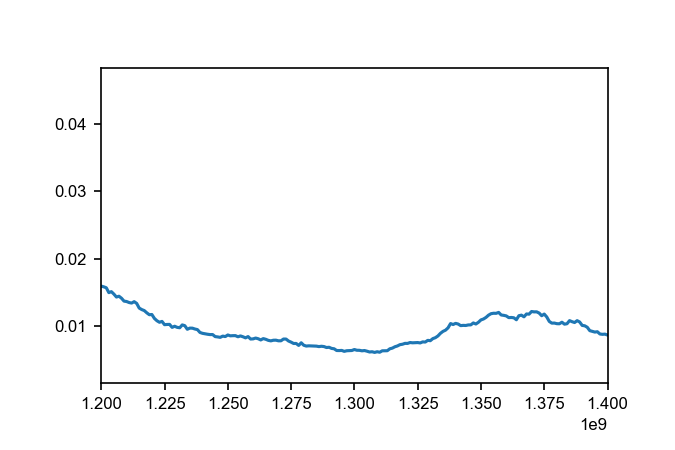

In [437]:
x = data[0][0]['data']
y = data[0][1]['data']

#y_test = data[4]['data']
#z = data[0][2]['data']
plt.figure()
plt.xlim([1200e6,1400e6])
plt.plot(x,y)

<IPython.core.display.Javascript object>


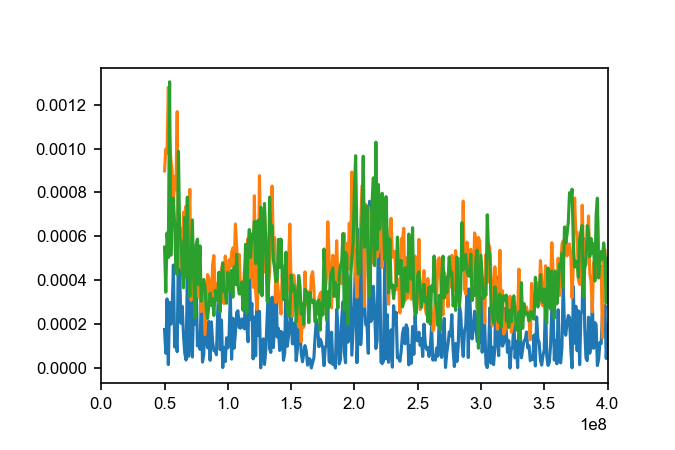

<IPython.core.display.Javascript object>


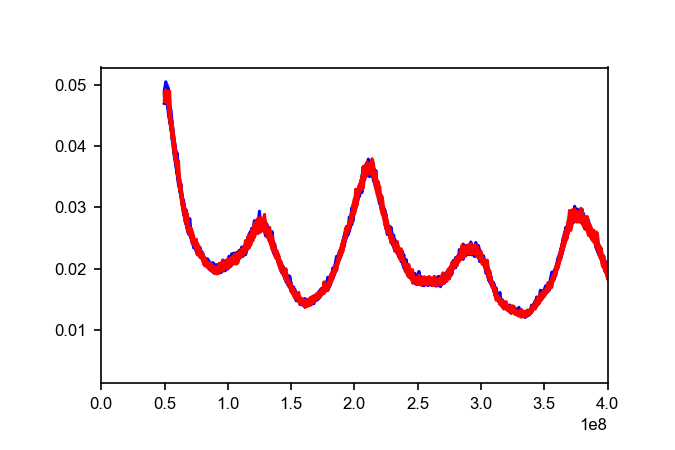

In [434]:
# processing frequency sweep data

x = data = get_data_by_id(393)[0][0]['data']
y = np.zeros((1450, 80))
for n in range(80):
    y[:,n] = data = get_data_by_id(393+n)[0][1]['data']
    
    
xrang = [0e6,400e6]
n1 = np.append(np.arange(0,4), np.arange(72,76))  # high conductance
n2 = n1 + 4 #np.append(np.arange(0,4), np.arange(8,12), np.arange(16,20))   # low conductance

plt.figure()
plt.xlim(xrang)
plt.plot(x,abs(np.mean(y[:,n1],axis=1)-np.mean(y[:,n2],axis=1)), x, np.std(y[:,n1],axis=1), x, np.std(y[:,n2],axis=1))

plt.figure()
#plt.ylim([0.01,0.0175])
plt.xlim(xrang)
for n in n1:
    plt.plot(x,y[:,n],'b')
for n in n2:
    plt.plot(x,y[:,n],'r')

In [204]:
np.unique(x).size

80

In [205]:
xx = x.reshape(200, 200)
yy = y.reshape(200, 200)
zz = z.reshape(200, 200)

ValueError: cannot reshape array of size 80 into shape (200,200)

<IPython.core.display.Javascript object>


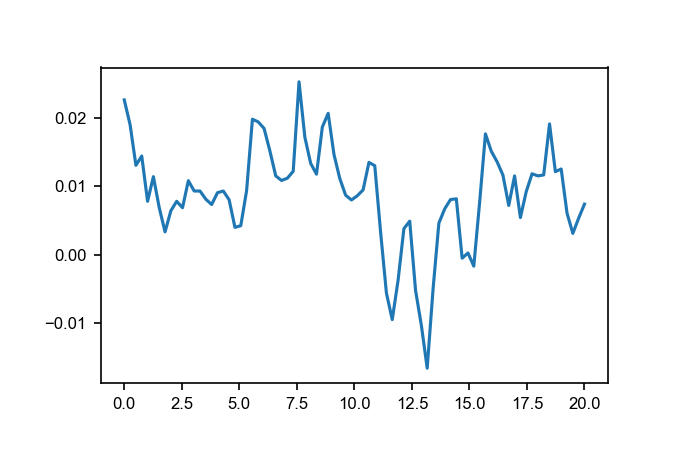

NameError: name 'y' is not defined

In [206]:
fig, ax = plt.subplots(1,1)
ax.plot(x, y)
#ax.imshow(zz)

In [ ]:
data = get_data_by_id(135)

In [ ]:
x = data[0][0]['data']
y = data[0][1]['data']

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(x,y)

In [ ]:
from lmfit.models import LorentzianModel, PolynomialModel, PowerLawModel

# make models for individual components
mod_bg = PolynomialModel(degree=5, prefix='poly_', independent_vars=['x'])
mod_lorentz = LorentzianModel(prefix='lo_')
mod_bg2 = PowerLawModel(prefix='power_', independent_vars=['x'])

# sum components to make a composite model (add more if needed)
model  = mod_bg + mod_lorentz
#model  = mod_bg2 + mod_lorentz

# create fitting parameters by name, give initial values
params = model.make_params(lo_amplitude=-10e3, lo_center=515.8e6, lo_sigma=3e5, 
                           poly_c0=1, poly_c1=1, poly_c2=0, poly_c3=0, poly_c4=0, poly_c5=0)
                           #power_amplitude=1, power_exponent=1)

# do fit
result = model.fit(y, params, x=x)

# print out fitting statistics, best-fit parameters, uncertainties,....
print(result.fit_report())

In [ ]:
out = model.fit(y, params, x=x)

plt.figure()
plt.plot(x, y, 'b')
plt.plot(x, out.best_fit, 'r-')
plt.show()

In [ ]:
center = params['lo_center'].value
sigma = params['lo_sigma'].value
Q = center/2/sigma
print(Q)

# DAC settings

In [566]:
print(station.ivvi.dac1()) #V_dc (2mV/V)
print(station.ivvi.dac2()) #V_dc
print(station.ivvi.dac3()) #CG1
print(station.ivvi.dac4())
print(station.ivvi.dac5()) #TG1
print(station.ivvi.dac6()) #TG2
print(station.ivvi.dac7()) #CG2
print(station.ivvi.dac8())
print(station.ivvi.dac9())
print(station.ivvi.dac10())

print(station.ivvi.dac11()) #PG1 coarse (1V/V)
print(station.ivvi.dac12()) #PG1 fine (10mV/V)
print(station.ivvi.dac13()) #PG1 coarse (1V/V)
print(station.ivvi.dac14()) #PG1 fine (10mV/V)
print(station.ivvi.dac15()) #PG1 fine (10mV/V)
print(station.ivvi.dac16())

100.00762951094839
0.03051804379333589
0.03051804379333589
400.0
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
0.03051804379333589
699.9923704890516
0.03051804379333589
300.0228885328447
0.03051804379333589
-600.0152590218968
0.03051804379333589


In [537]:
station.ivvi.dac1(0)

In [491]:
station.ivvi.dac3(0)

In [567]:
station.ivvi.dac4(0)

In [493]:
station.ivvi.dac5(0)

In [519]:
station.ivvi.dac6(0)

In [47]:
station.ivvi.dac1(0) #V_dc (10mV/V)

station.ivvi.dac2(0)
station.ivvi.dac3(0)

station.ivvi.dac4(0) #TG1 (1V/V)
station.ivvi.dac5(0) #SG (1V/V)
station.ivvi.dac6(0) #TG2 (1V/V)
station.ivvi.dac7(0) #SG2 (1V/V)
station.ivvi.dac8(0) #TG3 (1V/V)

station.ivvi.dac9(0) #PG1 (1V/V)
station.ivvi.dac10(0)

station.ivvi.dac11(0) #PG2 coarse (1V/V)
station.ivvi.dac12(0) #PG2 fine (10mV/V)

station.ivvi.dac13(0)
station.ivvi.dac14(0)

station.ivvi.dac15(0)
station.ivvi.dac16(0)

In [21]:
station.ivvi.dac1(0) #V_dc (10mV/V)

station.ivvi.dac2(0) #15V/V
station.ivvi.dac3(0)

station.ivvi.dac4(0) #TG1 (1V/V)
station.ivvi.dac5(0) #SG (1V/V)
station.ivvi.dac6(0) #TG2 (1V/V)
station.ivvi.dac7(0) #SG2 (1V/V)
station.ivvi.dac8(0) #TG3 (1V/V)

station.ivvi.dac9(0)
station.ivvi.dac10(0)

station.ivvi.dac11(0) #PG1 coarse (1V/V)
station.ivvi.dac12(0) #PG1 fine (10mV/V)

station.ivvi.dac13(0) #broken 1V=106mV on coarse setting, 1V=1mV on fine setting
station.ivvi.dac14(0) #broken 1V=5-6mV on fine setting, works on coarse setting

station.ivvi.dac15(0) #broken 1V=28mV on coarse setting, 1V=0mV on fine setting
station.ivvi.dac16(0) #broken 1V=151mV on coarse setting, 1V=0mV on fine setting

In [ ]:
# @getter(('conductance', 'asdsada'), ('qubit_gate_A', '%'))
# def get_conductance_and_qubit_parameters():
#     c_val = ivvi.dac1.voltage() /1000 * 23  # converts V to asdsada units
#     q_val = lockin.ch3.Y() + 5  # converts V to % units
#     return c_val, q_val


# @setter(('plunger_gate', 'V'))
# def set_plunger_gate(pg_val):
#     ivvi.dac4.voltage(pg_val - 35)
#     sleep(2)
#     lockin.update_smth()
#     make_coffee()
    

# my_conductance_plunger_measurement = \
# sweep(set_plunger_gate, [5, 10, 15])(
#     measure(get_conductance_and_qubit_parameters)
# )

# do_experiment('my_experiment', my_conductance_plunger_measurement)

# Magnetic field sweep

In [333]:
#station.AMI430_3D.cartesian() # read field components
#station.AMI430_3D.cartesian([0, 0, 0])
station.AMI430_3D.cartesian() # read field components

[1.2, -5e-05, -0.00018]

In [329]:
station.AMI430_3D.x() # read single component
station.AMI430_3D.z(1.25) # set single component
station.AMI430_3D.z() # read single component

1.2

In [40]:
station.AMI430_3D._instrument_x._get_ramp_rate()  #0.00002
station.AMI430_3D._instrument_y._get_ramp_rate() #0.00015
station.AMI430_3D._instrument_z._get_ramp_rate()  #0.00035

2e-05

In [45]:
station.AMI430_3D._instrument_x._set_ramp_rate(2e-5)
station.AMI430_3D._instrument_y._set_ramp_rate(1e-4)
station.AMI430_3D._instrument_z._set_ramp_rate(2.0e-4)

## PG vs Bx

In [720]:
new_experiment(name='PGvsBx_sweep', sample_name="U48_1.1")

station.ivvi.dac11(850) #PG
station.ivvi.dac12(0)

station.ivvi.dac13(700) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(0) #TG2
station.ivvi.dac16(0)

station.ivvi.dac1(44)
V_start = 0 #10mV/V
V_end = 400
n_steps = 401

ticc = time.time()

#station.ivvi.dac15(25+43)
#nest
#1st slow
#2nd fast


result = do_experiment("PGvsBx/U48_1.1",
        nest(
    sweep(station.AMI430_3D.x, np.linspace(0.0, 0.3, 301)), 
    sweep(station.ivvi.dac12, np.linspace(V_start, V_end, n_steps)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins')

Starting experimental run with id: 402
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
T

KeyboardInterrupt: 

In [721]:
station.AMI430_3D.x(0.270)

In [663]:
new_experiment(name='PGvsBx_sweep', sample_name="U48_1.1")

station.ivvi.dac11(2000) #PG
station.ivvi.dac12(0)

station.ivvi.dac13(950) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(410) #TG2
station.ivvi.dac16(0)

station.ivvi.dac1(45)
V_start = 0 #10mV/V
V_end = 400
n_steps = 401

ticc = time.time()

#station.ivvi.dac15(25+43)
#nest
#1st slow
#2nd fast


result = do_experiment("PGvsBx/U48_1.1",
        nest(
    sweep(station.AMI430_3D.x, np.linspace(1.2, 0.0, 121)), 
    sweep(station.ivvi.dac12, np.linspace(V_start, V_end, n_steps)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins')

Starting experimental run with id: 351
Measurement completed
time = 421.0141567746798 mins


## bias vs Bx

In [551]:
new_experiment(name='VbiasvsBx_sweep', sample_name="U48_1.1")

station.ivvi.dac11(700) #PG
station.ivvi.dac12(0)

station.ivvi.dac13(900) #TG1
station.ivvi.dac14(0)

station.ivvi.dac15(-556.5) #TG2
station.ivvi.dac16(0)
station.ivvi.dac1(-300+50)
V_start = -300 + 50 #2mV/V
V_end = 300 + 50
n_steps = 301

ticc = time.time()

#station.ivvi.dac15(25+43)
#nest
#1st slow
#2nd fast


result = do_experiment("VbiasvsBx/U48_1.1",
        nest(
    sweep(station.AMI430_3D.x, np.linspace(0.0, 1.5, 76)), 
    sweep(station.ivvi.dac1, np.linspace(V_start, V_end, n_steps)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins')

Starting experimental run with id: 252
Measurement completed
time = 357.3727146267891 mins


In [305]:
new_experiment(name='VbiasvsBx_sweep', sample_name="U48")

station.ivvi.dac3(0)
station.ivvi.dac4(200)
station.ivvi.dac5(-500)
station.ivvi.dac1(-700+66) #-400+105
V_start = -700 + 66 #2mV/V
V_end = 700 + 66
n_steps = 701
ticc = time.time()

#station.ivvi.dac15(25+43)
#nest
#1st slow
#2nd fast


result = do_experiment("VbiasvsBx/U48",
        nest(
    sweep(station.AMI430_3D.x, np.linspace(0.0, 1.6, 81)), 
    sweep(station.ivvi.dac1, np.linspace(V_start, V_end, n_steps)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins')

Starting experimental run with id: 114
Measurement completed


In [306]:
new_experiment(name='VbiasvsBx_sweep', sample_name="U48")

station.ivvi.dac3(0)
station.ivvi.dac4(200)
station.ivvi.dac5(-400)
station.ivvi.dac1(-700+66) #-400+105
V_start = -700 + 66 #2mV/V
V_end = 700 + 66
n_steps = 701
ticc = time.time()

#station.ivvi.dac15(25+43)
#nest
#1st slow
#2nd fast


result = do_experiment("VbiasvsBx/U48",
        nest(
    sweep(station.AMI430_3D.x, np.linspace(1.6, 0.0, 81)), 
    sweep(station.ivvi.dac1, np.linspace(V_start, V_end, n_steps)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )


Starting experimental run with id: 115
Measurement completed


KeyboardInterrupt: 

In [20]:
new_experiment(name="Vbias vs TG1", sample_name="")
field_list = np.array([0.1,0.3,0.4,0.5])#np.linspace(0.1, 1.2, 6)
for field in field_list:
    #station.ivvi.dac1(20) # 20mV/V
    theta = 20
    Bx = -field*np.cos(np.pi*theta/180)
    Bz = field*np.sin(np.pi*theta/180)
    station.AMI430_3D.cartesian([Bx, 0, Bz])
    station.AMI430_3D.cartesian()
    ticc = time.time()
    #x1_list = [50, 150, ]
    #nest
    #1st slow
    #2nd fast

    result = do_experiment("Vbias vs PG/D1 "+ str(field),
            nest(
        sweep(station.ivvi.dac15, np.linspace(-120, 80, 801)), 
        sweep(station.ivvi.dac1, np.linspace(-1500+43, 1500+43, 101)))(  # at 20mV/V, offset ~ 250
                measure(measure_DC)),
            [
                init_DC, 
                set_params,
            ],
            end_DC,
            live_plot=True
        )

    print('time = ' + str((time.time() - ticc)/60) + ' mins') 


Starting experimental run with id: 980
Measurement completed


KeyboardInterrupt: 

In [540]:
new_experiment(name='VbiasvsBG_sweep', sample_name="wires 1711")

#station.ivvi.dac1(43)

#station.ivvi.dac3(43)



#nest
#1st slow
#2nd fast


result = do_experiment("VbiasvsBG/wires 1711",
        nest(
    sweep(station.ivvi.dac3, np.linspace(150, 650, 20)), 
    sweep(station.ivvi.dac1, np.linspace(-500+43, 500+43, 20)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

Starting experimental run with id: 813
Measurement completed


In [195]:
ticc = time.time()
    #x1_list = [50, 150, ]
    #nest
    #1st slow
    #2nd fast

result = do_experiment("Vbias vs PG/D1 ",
        nest(
    sweep(station.ivvi.dac15, np.linspace(-120, -20, 401)), 
    sweep(station.ivvi.dac1, np.linspace(-1500+43, 1500+43, 151)))(  # at 20mV/V, offset ~ 250
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )

print('time = ' + str((time.time() - ticc)/60) + ' mins') 

Starting experimental run with id: 976
Measurement completed
time = 329.3290064175924 mins


In [136]:
station.AMI430_3D.z(0.0)

## QPC scan 

In [331]:
def import_raw_data(fileID, observe_col=0, col_x=0, col_y=1, col_z=None):
    data = get_data_by_id(fileID)
    if col_z==None:
        x = data[observe_col][col_x]['data']
        y = data[observe_col][col_y]['data']
        return x, y
    else:
        # expect data looks like : 
        #   x = [0,1,2,3,0,1,2,3, ...]
        #   y = [0,0,0,0,1,1,1,1, ...]
        x = data[observe_col][col_x]['data']
        y = data[observe_col][col_y]['data'] 
        z = data[observe_col][col_z]['data'] 
        if not(x[0]==x[1]):
            idx = np.nonzero(x == x[0])[0]
            len_x = idx[1]
        else:
            idx = np.nonzero(y == y[0])[0]
            len_x = idx[1]            
        if not (len(x) % len_x == 0):
            print('from function import_raw_data() : some points are missing in the last line')
            n_x = len(x) // len_x
            res_x = len(x) % len_x
            xx = x[0:len_x]
            yy = y[0:len_x]
            if xx[0]==xx[1]:
                x_last_line = np.ones((len_x-res_x,))*x[-1]
                y_last_line = yy[res_x:]
            else:
                x_last_line = xx[res_x:]
                y_last_line = np.ones((len_x-res_x,))*y[-1]
            x = np.append(x, x_last_line)
            y = np.append(y, y_last_line)
            z = np.append(z, np.ones((len_x-res_x,))*z[-1] )
        x=x.reshape((-1,len_x))
        y=y.reshape((-1,len_x))
        z=z.reshape((-1,len_x))
        if x[0,0]==x[1,0]:
            x=np.transpose(x)
            y=np.transpose(y)
            z=np.transpose(z)
        return x, y, z
            

In [377]:
field_list = np.linspace(0.0,0.9,10)
By_freq_d = {}
for field in field_list:
    station.ivvi.dac11(-400)
    station.AMI430_3D.y(field)
    station.AMI430_3D.cartesian()
    new_experiment(name='rf_frequency_sweep', sample_name="")

    station.hetsrc.IF(10.0e6)
    station.hetsrc.RF.on()
    station.hetsrc.LO.on()
    station.hetsrc.RF.power(0)
    station.hetsrc.LO.power(21)

    ctl = station.post_iq_acq
    #ctl.pre_acquire_func = station.awg.start
    #ctl.post_acquire_func = station.awg.stop
    ctl.average_buffers(False)
    ctl.setup_acquisition(samples=None, records=1, buffers=2, acq_time=2.0e-3)
    ctl.demod_frq(10e6)

    #station.ivvi.dac1(0)
    #station.ivvi.dac3(0)
    so = sweep(station.hetsrc.frequency, np.arange(160e6, 180e6, 0.1e6))(
        measure(get_IQ_inter),
    )
    result = do_experiment("frequency_sweep/D2 field " + str(field), so, live_plot=True)


    fileID = result.run_id
    x,y = import_raw_data(fileID, 0)
    freq0 = x[np.argmin(y)]
    By_freq_d[field] = freq0
    
    new_experiment(name='TG', sample_name="")

    station.hetsrc.IF(10e6)
    station.hetsrc.frequency(freq0)
    station.hetsrc.RF.on()
    station.hetsrc.LO.on()
    station.hetsrc.RF.power(0) #-45 previously
    station.hetsrc.LO.power(21) #15 previously

    ctl = station.post_iq_acq
    ctl.average_buffers(False)
    ctl.setup_acquisition(None, 1, 2, acq_time=20.0e-3)
    ctl.demod_frq(10e6)

    station.ivvi.dac1(100)


    so = sweep(station.ivvi.dac11, np.linspace(-400, 300, 351))(
       measure(measure_DC_and_IQ))

    result = do_experiment("TG1_sweep RF_and_DC/D2 map "  + str(field), so, [init_DC, set_params], end_DC, live_plot=True)

    '''
    new_experiment(name='PG', sample_name="")

    station.hetsrc.IF(10e6)
    station.hetsrc.frequency(freq0)
    station.hetsrc.RF.on()
    station.hetsrc.LO.on()
    station.hetsrc.RF.power(5) 
    station.hetsrc.LO.power(21) #15 previously

    ctl = station.post_iq_acq
    ctl.average_buffers(False)
    ctl.setup_acquisition(None, 1, 2, acq_time=2.0e-3)
    ctl.demod_frq(10e6)

    so = nest(
       sweep(station.ivvi.dac11, np.linspace(-800, 100, 301)),
       sweep(station.ivvi.dac1, np.linspace(-1900, 1900, 201))
       (measure(measure_kei_and_IQ))
    )


    result = do_experiment("QPC scan/D2" + str(field), so, [init_DC, set_params], end_DC, live_plot=True)
    '''

Setup capture: 3.198976 MB total
 * Buffers: 2 (1.599488 MB/buffer) | (Allocated buffers: 2 = 3.198976 MB)
 * Records: 1 (1.599488 MB/record)
 * Samples: 199936 (= 1999.36 us)
 * Channels: 2
Starting experimental run with id: 746
Setup capture: 32.0 MB total
 * Buffers: 2 (16.0 MB/buffer) | (Allocated buffers: 2 = 32.0 MB)
 * Records: 1 (16.0 MB/record)
 * Samples: 2000000 (= 20000.0 us)
 * Channels: 2
Currently allocated data not sufficient: Need {self.data_size}, have {self.data.size}
Allocating 8000000 elements (32.0 MB, dtype: <class 'numpy.int32'>)
Starting experimental run with id: 747
Measurement completed
Setup capture: 3.198976 MB total
 * Buffers: 2 (1.599488 MB/buffer) | (Allocated buffers: 2 = 3.198976 MB)
 * Records: 1 (1.599488 MB/record)
 * Samples: 199936 (= 1999.36 us)
 * Channels: 2
Starting experimental run with id: 748
Setup capture: 32.0 MB total
 * Buffers: 2 (16.0 MB/buffer) | (Allocated buffers: 2 = 32.0 MB)
 * Records: 1 (16.0 MB/record)
 * Samples: 2000000 (= 

In [390]:
field_list = np.linspace(0.7,0.0,9)
By_freq_d = [169000000,170000000,170800000,171800000,172800000,173200000,173800000,173900000]


for n,field in enumerate(field_list):
    station.ivvi.dac11(-400)
    station.AMI430_3D.y(field)
    station.AMI430_3D.cartesian()
    
    new_experiment(name='rf_frequency_sweep', sample_name="")

    station.hetsrc.IF(10.0e6)
    station.hetsrc.RF.on()
    station.hetsrc.LO.on()
    station.hetsrc.RF.power(0)
    station.hetsrc.LO.power(21)

    ctl = station.post_iq_acq
    #ctl.pre_acquire_func = station.awg.start
    #ctl.post_acquire_func = station.awg.stop
    ctl.average_buffers(False)
    ctl.setup_acquisition(samples=None, records=1, buffers=2, acq_time=1.0e-3)
    ctl.demod_frq(10e6)

    #station.ivvi.dac1(0)
    #station.ivvi.dac3(0)
    so = sweep(station.hetsrc.frequency, np.arange(50e6, 1000e6, 0.5e6))(
        measure(get_IQ_inter),
    )
    result = do_experiment("frequency_sweep/D2 field " + str(field), so, live_plot=True)
    

    #fileID = result.run_id
    #x,y = import_raw_data(fileID, 0)
    #freq0 = x[np.argmin(y)]
    freq0 = By_freq_d[n] 
    
    new_experiment(name='TG', sample_name="")

    station.hetsrc.IF(10e6)
    station.hetsrc.frequency(freq0)
    station.hetsrc.RF.on()
    station.hetsrc.LO.on()
    station.hetsrc.RF.power(0) #-45 previously
    station.hetsrc.LO.power(21) #15 previously

    ctl = station.post_iq_acq
    ctl.average_buffers(False)
    ctl.setup_acquisition(None, 1, 2, acq_time=20.0e-3)
    ctl.demod_frq(10e6)

    station.ivvi.dac1(100)


    so = sweep(station.ivvi.dac11, np.linspace(-400, 300, 351))(
       measure(measure_DC_and_IQ))

    result = do_experiment("TG1_sweep RF_and_DC/D2 map "  + str(field), so, [init_DC, set_params], end_DC, live_plot=True)

    '''
    new_experiment(name='PG', sample_name="")

    station.hetsrc.IF(10e6)
    station.hetsrc.frequency(freq0)
    station.hetsrc.RF.on()
    station.hetsrc.LO.on()
    station.hetsrc.RF.power(5) 
    station.hetsrc.LO.power(21) #15 previously

    ctl = station.post_iq_acq
    ctl.average_buffers(False)
    ctl.setup_acquisition(None, 1, 2, acq_time=2.0e-3)
    ctl.demod_frq(10e6)

    so = nest(
       sweep(station.ivvi.dac11, np.linspace(-800, 100, 301)),
       sweep(station.ivvi.dac1, np.linspace(-1900, 1900, 201))
       (measure(measure_kei_and_IQ))
    )


    result = do_experiment("QPC scan/D2" + str(field), so, [init_DC, set_params], end_DC, live_plot=True)
    '''

Setup capture: 1.599488 MB total
 * Buffers: 2 (0.799744 MB/buffer) | (Allocated buffers: 2 = 1.599488 MB)
 * Records: 1 (0.799744 MB/record)
 * Samples: 99968 (= 999.68 us)
 * Channels: 2
Starting experimental run with id: 771
Setup capture: 32.0 MB total
 * Buffers: 2 (16.0 MB/buffer) | (Allocated buffers: 2 = 32.0 MB)
 * Records: 1 (16.0 MB/record)
 * Samples: 2000000 (= 20000.0 us)
 * Channels: 2
Starting experimental run with id: 772
Measurement completed
Setup capture: 1.599488 MB total
 * Buffers: 2 (0.799744 MB/buffer) | (Allocated buffers: 2 = 1.599488 MB)
 * Records: 1 (0.799744 MB/record)
 * Samples: 99968 (= 999.68 us)
 * Channels: 2
Starting experimental run with id: 773
Setup capture: 32.0 MB total
 * Buffers: 2 (16.0 MB/buffer) | (Allocated buffers: 2 = 32.0 MB)
 * Records: 1 (16.0 MB/record)
 * Samples: 2000000 (= 20000.0 us)
 * Channels: 2
Starting experimental run with id: 774
Measurement completed
Setup capture: 1.599488 MB total
 * Buffers: 2 (0.799744 MB/buffer) | 

IndexError: list index out of range

In [387]:
idlist = range(746, 766, 2)
for fileID in idlist:    
    x,y = import_raw_data(fileID, 0)
    freq0 = x[np.argmin(y)]
    print(freq0)


173900000
173800000
173200000
172800000
171800000
170800000
170000000
169000000
168300000
167600000


In [385]:
By_freq_d[0.9]

1

## magnetic field vs TG

In [317]:

station.ivvi.dac11(-800)
station.ivvi.dac1(0)

new_experiment(name='TG1vsTG2_sweep', sample_name="U32")

result = do_experiment("TG1vsBz/D2",
        nest(
    sweep(station.AMI430_3D.z, np.linspace(0, 3.9, 40)), 
    sweep(station.ivvi.dac11, np.linspace(-800, 200, 500)))(
            measure(measure_DC)),
        [
            init_DC, 
            set_params,
        ],
        end_DC,
        live_plot=True
    )



Starting experimental run with id: 702
Measurement completed
time = 357.4722185254097 mins


## RF freq sweep and TG1 sweep at different magnetic field 

In [335]:
station.ivvi.dac1(0)

In [337]:

#station.AMI430_3D.z(0.0)
station.AMI430_3D.cartesian() # read field components

[0.0, 0.0, 0.0]

In [363]:
new_experiment(name='rf_frequency_sweep', sample_name="")

station.hetsrc.IF(10.0e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(0)
station.hetsrc.LO.power(21)

ctl = station.post_iq_acq
#ctl.pre_acquire_func = station.awg.start
#ctl.post_acquire_func = station.awg.stop
ctl.average_buffers(False)
ctl.setup_acquisition(samples=None, records=1, buffers=2, acq_time=1.0e-3)
ctl.demod_frq(10e6)

#station.ivvi.dac1(0)
#station.ivvi.dac3(0)
so = nest(
   sweep(station.AMI430_3D.y, np.linspace(0.8, 0.0, 81)),
   sweep(station.hetsrc.frequency, np.arange(140e6, 200e6, 0.2e6))
   (measure(get_IQ_inter))
)
result = do_experiment("frequency vs By/D2 ", so, live_plot=True)

Setup capture: 1.599488 MB total
 * Buffers: 2 (0.799744 MB/buffer) | (Allocated buffers: 2 = 1.599488 MB)
 * Records: 1 (0.799744 MB/record)
 * Samples: 99968 (= 999.68 us)
 * Channels: 2
Starting experimental run with id: 741
Timeout during sending!
Timeout during sending!
Timeout during sending!


In [362]:
station.hetsrc.RF.power(0)

In [260]:
station.ivvi.dac1(500) #2mV/V
station.ivvi.dac3(490)

station.ivvi.dac6(0)
station.ivvi.dac7(-200)
station.ivvi.dac13(0)

#-----------------------------------------------
new_experiment(name='TG', sample_name="")

station.hetsrc.IF(10e6)
station.hetsrc.frequency(1.66e8)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(0) #-45 previously
station.hetsrc.LO.power(21) #15 previously

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=10.0e-3)
ctl.demod_frq(10e6)


#so = nest(
#   sweep(station.ivvi.dac1, np.linspace(-400, 400, 80))(
#   measure(measure_DC_and_IQ))    
#)

station.ivvi.dac1(100)


so = sweep(station.ivvi.dac11, np.linspace(-800, 400, 601))(
   measure(measure_DC_and_IQ))

result = do_experiment("QPC_sweep RF_and_DC/D2 field 3_0", so, [init_DC, set_params], end_DC, live_plot=True)

Setup capture: 15.998975999999999 MB total
 * Buffers: 2 (7.9994879999999995 MB/buffer) | (Allocated buffers: 2 = 15.998975999999999 MB)
 * Records: 1 (7.9994879999999995 MB/record)
 * Samples: 999936 (= 9999.36 us)
 * Channels: 2
Currently allocated data not sufficient: Need {self.data_size}, have {self.data.size}
Allocating 3999744 elements (15.998975999999999 MB, dtype: <class 'numpy.int32'>)
Starting experimental run with id: 683
Measurement completed


# AWG sweep

In [ ]:
station.awg.ch1_offset(0.0)

In [23]:
print(station.awg.ch1_offset())
print(station.awg.ch2_offset())

0.0
0.0


In [ ]:
station.hetsrc.IF(50e6)
station.hetsrc.frequency(515.5e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(-45)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=1e-3)
ctl.demod_frq(50e6)


so = sweep(station.awg.ch1_offset, np.linspace(0.03, -0.03, 300))(
    measure(get_IQ),
)
result = do_experiment("first_frequency_sweep/CQ_03_0205", so, live_plot=True)

In [ ]:
station.hetsrc.IF(50e6)
station.hetsrc.frequency(515.5e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(-45)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=1e-3)
ctl.demod_frq(50e6)


so = sweep(station.awg.ch1_offset, np.linspace(-0.08, -0.05, 200))(
    measure(get_IQ),
)
result = do_experiment("first_frequency_sweep/CQ_03_0205", so, live_plot=True)

In [ ]:
station.hetsrc.IF(50e6)
station.hetsrc.frequency(515.5e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(-45)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=50e-6)
ctl.demod_frq(50e6)

station.ivvi.dac1(0)
station.ivvi.dac6(-65)
station.ivvi.dac8(-48)

so = sweep(station.ivvi.dac12, np.linspace(1000.0, 2000.0, 1000))(
    measure(get_IQ),
)
result = do_experiment("first_frequency_sweep/CQ_03_0205", so, live_plot=True)

In [ ]:
#TG2 vs TG3 sweep

station.hetsrc.IF(50e6)
station.hetsrc.frequency(515.5e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(-45)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=50e-6)
ctl.demod_frq(50e6)

station.ivvi.dac1(50)
#station.ivvi.dac6(-65)
#station.ivvi.dac8(-37)

so = Nest(
    sweep(station.ivvi.dac8, np.linspace(-40, -50, 100)),
    sweep(station.ivvi.dac6, np.linspace(-60, -70, 100)))(
    measure(get_IQ),
)
result = do_experiment("first_frequency_sweep/CQ_03_0205", so, live_plot=True)

In [ ]:
station.hetsrc.IF(50e6)
station.hetsrc.frequency(515.5e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(-45)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.setup_acquisition(None, 1, 2, acq_time=1e-3)
ctl.demod_frq(50e6)


so = Nest(
    sweep(station.awg.ch1_offset, np.linspace(-0.05, -0.08, 31)),
    sweep(station.ivvi.dac1, np.linspace(-500, 500, 200)))(
    measure(get_IQ),
)
result = do_experiment("first_frequency_sweep/CQ_03_0205", so, live_plot=True)

## Softsweep

In [303]:
from pytopo.rf.alazar.awg_sequences import TriggerSequence

TriggerSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', None],
}

ctl = station.post_iq_acq
ctl.pre_acquire_func = station.awg.force_trigger
ctl.average_buffers(False)
ctl.demod_frq(20e6)

samples = 1024 #this is a dummy number, if acq_time is specified that's what determines the number of samples
records = 1
buffers = 2
acq_time = 50e-6

ctl.setup_acquisition(samples, records, buffers, acq_time=acq_time)

ro_trigger = TriggerSequence(station.awg, SR=1e7)

Setup capture: 0.159744 MB total
 * Buffers: 2 (0.079872 MB/buffer) | (Allocated buffers: 2 = 0.159744 MB)
 * Records: 1 (0.079872 MB/record)
 * Samples: 9984 (= 49.92 us)
 * Channels: 2


ro_trigger not defined. omitting.


<IPython.core.display.Javascript object>


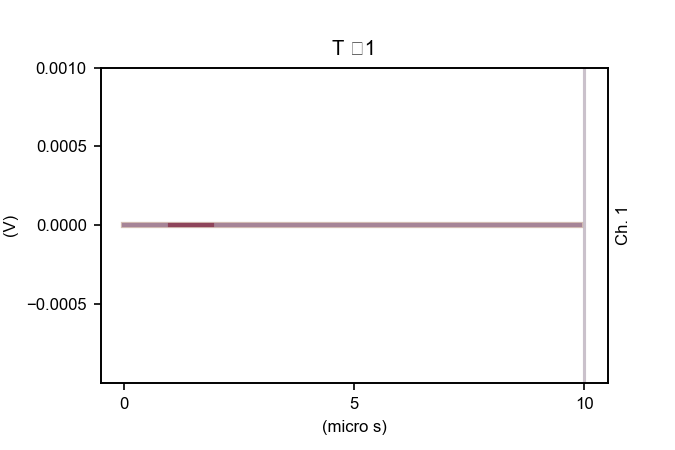

In [304]:
ro_trigger.setup_awg(program_awg=True, plot=True, start_awg=False)

In [309]:
#data = ctl.acquisition()

In [305]:
from pytopo.rf.alazar.awg_sequences import AlazarTestSequence

AlazarTestSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', None]
}
AlazarTestSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}

<IPython.core.display.Javascript object>


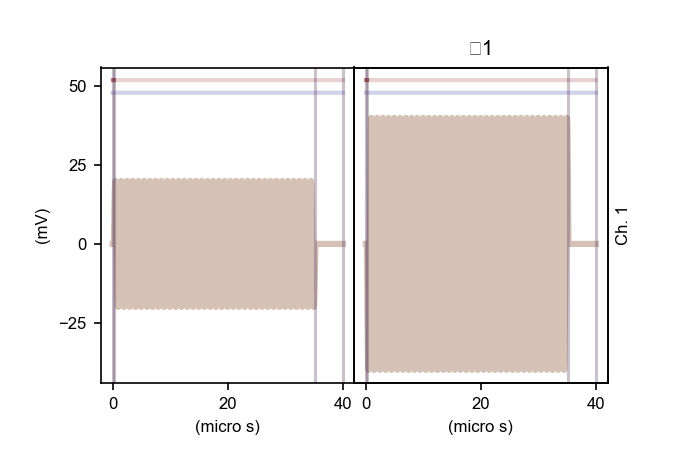

In [307]:
N = 2
pulse_times = [35e-6] * N
amplitudes = np.arange(N) * 0.02 + 0.02
frequencies = [1e6] * N
phases = np.arange(N) * 2 * np.pi/N
cycle_time = 40e-6

test_seq = AlazarTestSequence(station.awg)
test_seq.wait = 'off' #AWG doesn't wait for a trigger
test_seq.setup_awg(pulse_times=pulse_times, frequencies=frequencies, 
                   phases=phases, amplitudes=amplitudes, 
                   cycle_time=cycle_time, pre_trig_time=0.1e-6, trig_time=0.1e-6,
                   plot=True, start_awg=False)

## Raw data

In [337]:
ctl = station.raw_acq
GateRampSequence_2axes.wait = 'first' #the AWG will wait for the first trigger
gateramp2d_seq = GateRampSequence_2axes(station.awg, SR=1e7)
gateramp2d_seq.setup_awg(npoints_x=3, npoints_y=3, time_per_point=45e-6, 
                         biasval_start=-400e-6, biasval_stop=400e-6, 
                         gateval_start=0.00, gateval_stop=0.008, 
                         plot=False, start_awg=True)

t_rep = 40e-6
nsamples = 3840 // 2
npts = int(1e3)
nrecords = 100
alloc_buffers = 10
SR = 1e8

t_total = npts * t_rep
nbuffers = npts // nrecords

ctl.pre_acquire_func = station.awg.force_trigger
#ctl.post_acquire_func = station.awg.stop

t, data = acquisition_tools.time_acquisition(ctl, nsamples, nrecords, nbuffers, 
                                             alloc_buffers=alloc_buffers, SR=SR, t_total=t_total)

Setup capture: 7.679999999999999 MB total
 * Buffers: 10 (0.7679999999999999 MB/buffer) | (Allocated buffers: 10 = 7.679999999999999 MB)
 * Records: 100 (0.007679999999999999 MB/record)
 * Samples: 1920 (= 19.2 us)
 * Channels: 2
done: 0.4855601728777401 s
Acquistion: 0.152350 sec.
Net time: 0.040000 sec.
Overhead: 3.81 X
Mean buffer handling time: 0.1 ms
post_acquire time: 0.06 s
Data shape: (1, 10, 100, 1920, 2)

 buffers cleared
buffers cleared
Captured 10 buffers (144.944213 buffers per sec)
Captured 1000 records (14494.421325 records per sec)
Transferred 7.68e+06 bytes (1.11317e+08 bytes per sec)
Pre setup took 0.023459312389604747
Pre capture setup took 0.00047329755034297705
Capture took 0.046097538608592004
abort took 0.020289039937779307
handling took 0.0011993723164778203
free mem took 0.0009081799944397062
tot acquire time is 0.0924513733771164



# Gate ramp measurement

## 1-axis hardsweep

In [ ]:
new_experiment(name='rf_gate_sweep', sample_name="U32")

In [28]:
@hardsweep(ind=[('voltage', 'V', 'array')], dep=[('signal_mag', 'V', 'array')])
def measure_sweep_1d(parameter_vals):
    ctl = qc.Station.default.post_iq_acq
    data = ctl.acquisition()
    mag = np.squeeze(np.abs(data))[...,0]
    return parameter_vals, mag

### Gate voltage

In [158]:
#Fast gate sweep:

RampSequence.chan_map = {
    1 : ['parameter', 'ats_trigger', None]
}
RampSequence.chan_settings = {
    1 : {
        'Vpp' : 0.5,
        'offset' : 0.,
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}
RampSequence.voltage_scale_factor = 0.2 #100mV/V x 2

In [159]:
npoints=401
RampSequence.wait = 'off' #AWG doesn't wait for a trigger
gateramp1d_seq = RampSequence(station.awg, SR=1e7)
gateramp1d_seq.setup_awg(npoints=npoints, time_per_point=45e-6, 
                         val_start=0.00, val_stop=0.016, 
                         plot=False, start_awg=False)

parameter_vals = gateramp1d_seq.parameter_vals

In [ ]:
station.hetsrc.IF(20e6)
station.hetsrc.frequency(515.8e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(-60)
station.hetsrc.LO.power(15)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.demod_frq(20e6)

#Change alazar.trigger_source1 to EXTERNAL:
ctl.pre_acquire_func = station.awg.start # .force_trigger
ctl.post_acquire_func = station.awg.stop
ctl.setup_acquisition(samples=None, records=npoints, buffers=1, acq_time=40e-6)

In [ ]:
station.awg.sample_rate()

In [396]:
station.ivvi.dac1(0)
ctl = qc.Station.default.post_iq_acq
data = ctl.acquisition() #actual measurement
mag = np.squeeze(np.abs(data))[...,0]

<IPython.core.display.Javascript object>


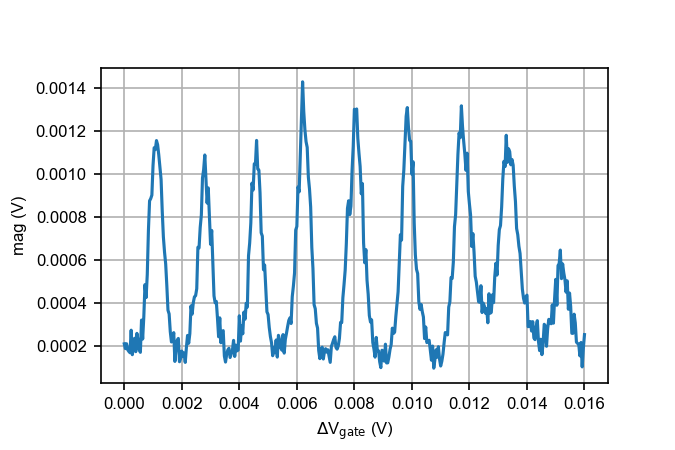

Text(0, 0.5, 'mag (V)')

In [397]:
fig, ax = plt.subplots(1,1)
ax.plot(parameter_vals/5, mag)
ax.grid()
ax.set_xlabel('$\Delta$V$_{\mathrm{gate}}$ (V)')
ax.set_ylabel('mag (V)')

In [377]:
so = sweep(station.ivvi.dac1, np.linspace(45, -45, 201))(
    measure_sweep_1d(parameter_vals)
)

result = do_experiment("gate_sweep/CQ_03_0205", so, live_plot=True)

Starting experimental run with id: 327


### Bias voltage

In [ ]:
#Fast bias sweep:

RampSequence.chan_map = {
    1 : [None, 'ats_trigger', None],
    2 : ['parameter', None, None],
}
RampSequence.chan_settings = {
    1 : {
        'Vpp' : 0.5,
        'offset' : 0.,
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
    2 : {
        'Vpp' : 4.5,
        'offset' : 0.,
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}
RampSequence.voltage_scale_factor = 2e-4 #100mV/V x 2

In [ ]:
RampSequence.wait = 'off' #AWG doesn't wait for a trigger
ramp1d_seq = RampSequence(station.awg, SR=1e7)
ramp1d_seq.setup_awg(npoints=201, time_per_point=45e-6, 
                     val_start=-450e-6, val_stop=450e-6, 
                     plot=False, start_awg=False)

parameter_vals = ramp1d_seq.parameter_vals

In [ ]:
station.hetsrc.IF(20e6)
station.hetsrc.frequency(515.8e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(-60)
station.hetsrc.LO.power(15)

ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.demod_frq(20e6)

#Change alazar.trigger_source1 to EXTERNAL:
ctl.pre_acquire_func = station.awg.start # .force_trigger
ctl.post_acquire_func = station.awg.stop
ctl.setup_acquisition(samples=None, records=201, buffers=1, acq_time=40e-6)

In [ ]:
ctl = qc.Station.default.post_iq_acq
data = ctl.acquisition()
mag = np.squeeze(np.abs(data))[...,0]

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(parameter_vals*2e-4, mag)
ax.grid()
ax.set_xlabel('V$_{\mathrm{bias}}$ (V)')
ax.set_ylabel('mag (V)')

In [ ]:
so = sweep(station.ivvi.dac12, np.linspace(1600, 0, 801))(
    measure_sweep_1d(parameter_vals)
)

result = do_experiment("gate_sweep/CQ_03_0205", so, live_plot=True)

## 2-axes hardsweep

In [ ]:
new_experiment(name='rf_2axes_sweep', sample_name="U32")

In [404]:
GateRampSequence_2axes.chan_map = {
    1 : ['gate', 'ats_trigger', None],
    2 : ['bias', None, None],
}
GateRampSequence_2axes.chan_settings = {
    1 : {
        'Vpp' : 0.5,
        'offset' : 0.,
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
    2 : {
        'Vpp' : 4.5,
        'offset' : 0.,
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}
GateRampSequence_2axes.voltage_scale_factor_x = 2e-4 #10mV/V x 2/100
GateRampSequence_2axes.voltage_scale_factor_y = 0.2 #100mV/V x 2

In [405]:
@hardsweep(ind=[('voltage_1', 'V', 'array'),
                ('voltage_2', 'V', 'array')], 
           dep=[('signal_mag', 'V', 'array')])
def measure_gatesweep_2d(voltages1, voltages2):
    ctl = qc.Station.default.post_iq_acq
    data = ctl.acquisition()
    mag = np.squeeze(np.abs(data))[...,0].reshape(-1)
    
    v1, v2 = np.meshgrid(voltages1, voltages2, indexing='ij')
    return np.vstack((v1.reshape(-1), v2.reshape(-1))), mag

In [420]:
station.alazar.external_sample_rate?

In [449]:
npoints_x=201
npoints_y=401 #fast axis

GateRampSequence_2axes.ramp_down_time = 100e-6
GateRampSequence_2axes.initial_delay = 10e-6

GateRampSequence_2axes.wait = 'off' #AWG doesn't wait for a trigger
gateramp2d_seq = GateRampSequence_2axes(station.awg, SR=1e7)
gateramp2d_seq.setup_awg(npoints_x=npoints_x, npoints_y=npoints_y, time_per_point=45e-6, 
                         biasval_start=-400e-6, biasval_stop=400e-6, 
                         gateval_start=0.00, gateval_stop=0.008, 
                         plot=False, start_awg=False)

biasvals = gateramp2d_seq.bias_vals
gatevals = gateramp2d_seq.gate_vals

station.hetsrc.IF(20e6)
station.hetsrc.frequency(515.8e6)
station.hetsrc.RF.on()
station.hetsrc.LO.on()
station.hetsrc.RF.power(-60)
station.hetsrc.LO.power(15)


ctl = station.post_iq_acq
ctl.average_buffers(False)
ctl.demod_frq(20e6)
ctl.pre_acquire_func = station.awg.start # .force_trigger
ctl.post_acquire_func = station.awg.stop
ctl.setup_acquisition(samples=None, records=npoints_y, buffers=npoints_x, 
                      acq_time=40e-6, allocated_buffers=15)

Setup capture: 2558.598144 MB total
 * Buffers: 201 (12.729344000000001 MB/buffer) | (Allocated buffers: 15 = 190.94016000000002 MB)
 * Records: 401 (0.031744 MB/record)
 * Samples: 3968 (= 39.68 us)
 * Channels: 2


In [428]:
4000 * 2 * 2 * 401 * 101 * 2 * 1e-6 #samples*channels*bytes/byte*buffers*records*float

1296.032

In [450]:
%%time
so = measure_gatesweep_2d(biasvals, gatevals)

result = do_experiment("gate_sweep/CQ_03_0205", so, live_plot=True)

Starting experimental run with id: 346


RuntimeError: ('error 579: ApiWaitTimeout: operation did not finish during timeout interval. Check your trigger. from function AlazarWaitAsyncBufferComplete with args: [1076, c_void_p(1822425088), 10000]', 'getting post_iq_acq_acquisition')

In [442]:
%%time
from qcodes.instrument.parameter import Parameter
reps = Parameter(name='averages', set_cmd=None)

# so = sweep(ivvi.dac_coarse, np.arange(10.) * 0.04)(
# sweep(reps, np.arange(10.).astype(float))(
#     measure_gatesweep_2d(biasvals, gatevals)
# )
so = sweep(reps, np.arange(10.).astype(float))(
    measure_gatesweep_2d(biasvals, gatevals)
)

result = do_experiment("gate_sweep/CQ_03_0205", so, live_plot=True)

Starting experimental run with id: 341
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Timeout during sending!
Wall time: 3min 49s


In [ ]:
b = station.alazar.buffer_list[-2]

In [ ]:
for b in station.alazar.buffer_list:
    print(np.frombuffer(b.buffer))

In [ ]:
np.frombuffer(b.buffer)

In [ ]:
ctl.samples_per_record()

In [ ]:
station.alazar.sample_rate()/1e8

In [ ]:
station.alazar.trigger_source1('EXTERNAL')

In [416]:
45e-6 * 201 * 101 + 101 * 200e-6

0.933745